### Data Science, Classification Analysis 

## Data Cleaning, Feature Engineering, Imputation, and Classification.

This Notepad has been designed to be run on top of the Jupyter Tensorflow Docker instance found in the link below: 
- https://github.com/jupyter/docker-stacks/tree/master/tensorflow-notebook

### Checking Number of CPU's available to Docker container

Ideally, and for this Notebook to run in a reasonable time, your Docker container should have 4 cores or more available.

In [1]:
!cat /proc/cpuinfo | awk '/^processor/{print $3}' | tail -1

1


## Import Standard Python Libraries

In [2]:
import io, os, sys, types, time, datetime, math, random, requests, subprocess, tempfile
from io import StringIO

## Packages Import

These are all the packages we'll be using. Importing individual libraries make it easy for us to use them without having to call the parent libraries.

In [182]:
# Data Manipulation 
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Visualization 
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
from pandas.tools.plotting import scatter_matrix
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.graphics.mosaicplot import mosaic

# Feature Selection and Encoding
from sklearn.feature_selection import RFE, RFECV
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine learning 
import sklearn.ensemble as ske
from sklearn import datasets, model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf

# Grid and Random Search
import scipy.stats as st
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Metrics
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc

# Managing Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plot the Figures Inline
%matplotlib inline

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Listing Installed Packages

We could list all installed packages to check whether a package has already been installed.

In [4]:
conda_packages_list = io.BytesIO(subprocess.Popen(["conda", "list"], 
                                                         stdout=subprocess.PIPE).communicate()[0])
conda_packages_list = pd.read_csv(conda_packages_list, 
                                  names=['Package Name','Version','Python Version','Repo','Other'], 
                                  delim_whitespace=True, engine='python', skiprows=3)
conda_packages_list.head(5)

,Package Name,Version,Python Version,Repo,Other
0,asn1crypto,0.22.0,py36_0,conda-forge,None
1,backports,1.0,py36_1,conda-forge,None
2,backports.functools_lru_cache,1.4,py36_1,conda-forge,None
3,backports.weakref,1.0rc1,py36_1,conda-forge,None
4,beautifulsoup4,4.6.0,py36_0,conda-forge,None


## Objective

In this Jupyter Notepad, we will using the Mushroom Dataset to predict whether a Mushroom is edible or poisonous.
This dataset includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family Mushroom drawn from The Audubon Society Field Guide to North American Mushrooms (1981). Each species is identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended. This latter class was combined with the poisonous one. The Guide clearly states that there is no simple rule for determining the edibility of a mushroom; no rule like "leaflets three, let it be'' for Poisonous Oak and Ivy.

The dataset can be found here: https://archive.ics.uci.edu/ml/datasets/Mushroom

## Data Download and Loading

Let's download the data and save it to a folder in our local directory called 'dataset'. Download it once, and then comment the code out for subsequent runs.

After downloading the data, we load it directly from Disk into a Pandas Dataframe in Memory. Depending on the memory available to the Docker instance, this may be a problem.

The data comes separated into the Training and Test datasets. We will join the two for data exploration, and then separate them again before running our algorithms.

In [5]:
# Download
DATASET = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data",
    "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.names",

)

def download_data(path='dataset', urls=DATASET):
    if not os.path.exists(path):
        os.mkdir(path)

    for url in urls:
        response = requests.get(url)
        name = os.path.basename(url)
        with open(os.path.join(path, name), 'wb') as f:
            f.write(response.content)

download_data()

Number of Instances: 8124

Number of Attributes: 22 (all nominally valued)

Attribute Information: (classes: edible=e, poisonous=p)
     1. cap-shape: bell=b, conical=c, convex=x, flat=f, knobbed=k, sunken=s
     2. cap-surface:fibrous=f, grooves=g, scaly=y, smooth=s
     3. cap-color: brown=n, buff=b, cinnamon=c, gray=g, green=r, pink=p, purple=u, red=e, white=w, yellow=y
     4. bruises?: bruises=t,no=f
     5. odor: almond=a, anise=l, creosote=c, fishy=y, foul=f, musty=m, none=n, pungent=p, spicy=s
     6. gill-attachment: attached=a,descending=d,free=f,notched=n
     7. gill-spacing: close=c,crowded=w,distant=d
     8. gill-size:broad=b,narrow=n
     9. gill-color:black=k,brown=n,buff=b,chocolate=h,gray=g, green=r,orange=o,pink=p,purple=u,red=e,white=w,yellow=y
    10. stalk-shape: enlarging=e,tapering=t
    11. stalk-root: bulbous=b, club=c, cup=u, equal=e, rhizomorphs=z, rooted=r, missing=?
    12. stalk-surface-above-ring: fibrous=f, scaly=y, silky=k, smooth=s
    13. stalk-surface-below-ring: fibrous=f, scaly=y, silky=k, smooth=s
    14. stalk-color-above-ring:   brown=n, buff=b, cinnamon=c, gray=g, orange=o, pink=p,red=e,white=w,yellow=y
    15. stalk-color-below-ring:   brown=n, buff=b, cinnamon=c, gray=g, orange=o,pink=p,red=e,white=w,yellow=y
    16. veil-type: partial=p,universal=u
    17. veil-color: brown=n,orange=o,white=w,yellow=y
    18. ring-number: none=n,one=o,two=t
    19. ring-type: cobwebby=c,evanescent=e,flaring=f,large=l, none=n,pendant=p,sheathing=s,zone=z
    20. spore-print-color: black=k, brown=n, buff=b, chocolate=h, green=r, orange=o, purple=u, white=w, yellow=y
    21. population: abundant=a,clustered=c,numerous=n, scattered=s,several=v,solitary=y
    22. habitat:grasses=g,leaves=l,meadows=m,paths=p, urban=u,waste=w,woods=d

In [6]:
# Load the dataset

headers = ['Class', 'CapShape',
          'CapSurface', 'CapColor',
          'Bruises', 'Odor',
          'GillAttachment','GillSpacing',
          'GillSize','GillColor',
          'StalkShape', 'StalkRoot',
          'StalkAboveRing', 'StalkBelowRing',
          'ColorAboveRing', 'ColorBelowRing',
          'VeilType', 'VeilColor',
          'RingNumber', 'RingType',
          'SporeColor','Population',
          'Habitat']

dataset_raw = pd.read_csv("dataset/agaricus-lepiota.data",
                      header = None,
                      names = headers,
                      sep = ',',
                      na_values=["?"],
                      engine='python')
dataset_raw.head()

,Class,CapShape,CapSurface,CapColor,Bruises,Odor,GillAttachment,GillSpacing,GillSize,GillColor,...,StalkBelowRing,ColorAboveRing,ColorBelowRing,VeilType,VeilColor,RingNumber,RingType,SporeColor,Population,Habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [8]:
# Displaying the size of the dataframe in Memory
def convert_size(size_bytes):
    if size_bytes == 0:
        return "0B"
    size_name = ("Bytes", "KB", "MB", "GB", "TB")
    i = int(math.floor(math.log(size_bytes, 1024)))
    p = math.pow(1024, i)
    s = round(size_bytes / p, 2)
    return "%s %s" % (s, size_name[i])

convert_size(dataset_raw.memory_usage().sum())

'1.43 MB'

## Data Explorations

Let's start with some simple Univariate (one feature) analysis.

Features can be of multiple types:
- **Nominal:**  is for mutual exclusive, but not ordered, categories.
- **Ordinal:** is one where the order matters but not the difference between values.
- **Interval:** is a measurement where the difference between two values is meaningful.
- **Ratio:** has all the properties of an interval variable, and also has a clear definition of 0.0.

There are multiple ways of manipulating each feature type, but for simplicity, we'll define only two feature types:
- **Numerical:** any feature that contains numeric values.
- **Categorical:** any feature that contains categories, or text.

In [9]:
# Describing all the Categorical Features
dataset_raw.describe(include=['O'])

,Class,CapShape,CapSurface,CapColor,Bruises,Odor,GillAttachment,GillSpacing,GillSize,GillColor,...,StalkBelowRing,ColorAboveRing,ColorBelowRing,VeilType,VeilColor,RingNumber,RingType,SporeColor,Population,Habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


In [10]:
dataset_raw.shape

(8124, 23)

In [11]:
dataset_raw.dtypes

Class             object
CapShape          object
CapSurface        object
CapColor          object
Bruises           object
Odor              object
GillAttachment    object
GillSpacing       object
GillSize          object
GillColor         object
StalkShape        object
StalkRoot         object
StalkAboveRing    object
StalkBelowRing    object
ColorAboveRing    object
ColorBelowRing    object
VeilType          object
VeilColor         object
RingNumber        object
RingType          object
SporeColor        object
Population        object
Habitat           object
dtype: object

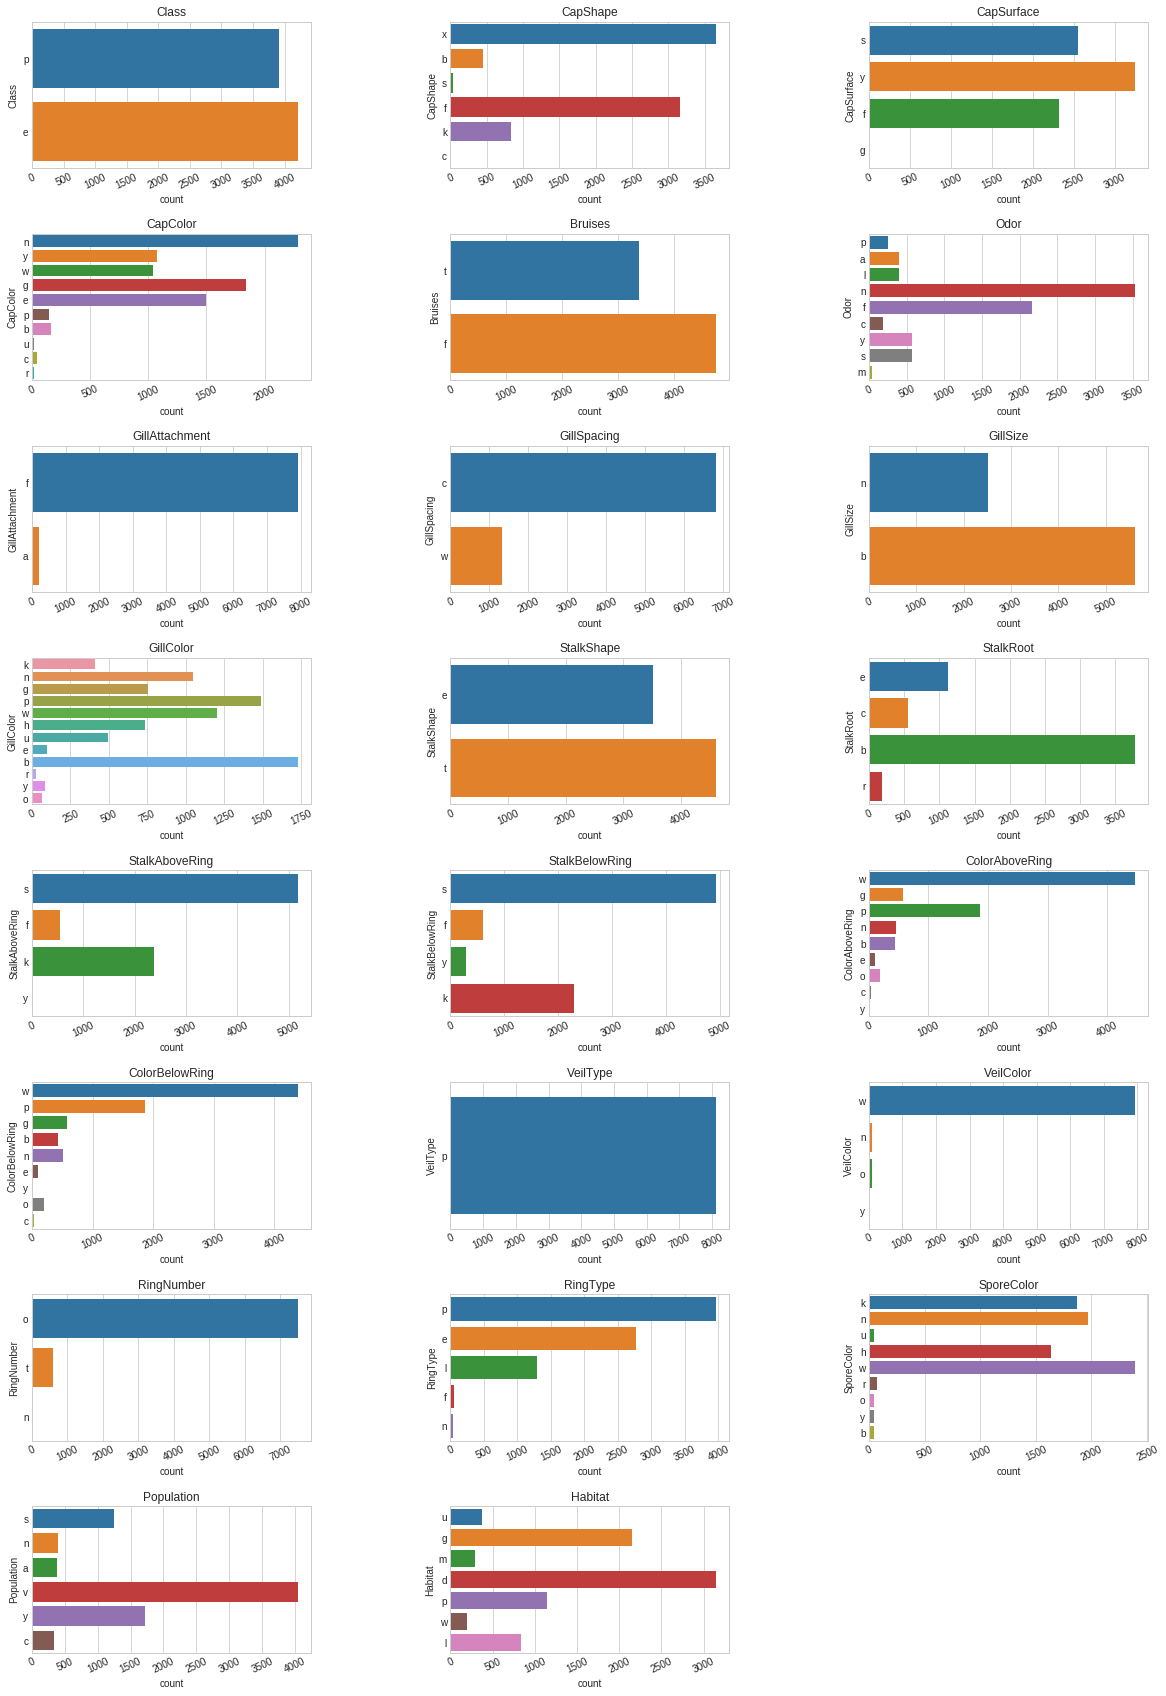

In [13]:
# Let’s plot the distribution of each feature
def plot_distribution(dataset, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if dataset.dtypes[column] == np.object:
            g = sns.countplot(y=column, data=dataset)
            substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            plt.xticks(rotation=25)
        else:
            g = sns.distplot(dataset[column])
            plt.xticks(rotation=25)
    
plot_distribution(dataset_raw, cols=3, width=20, height=30, hspace=0.45, wspace=0.5)

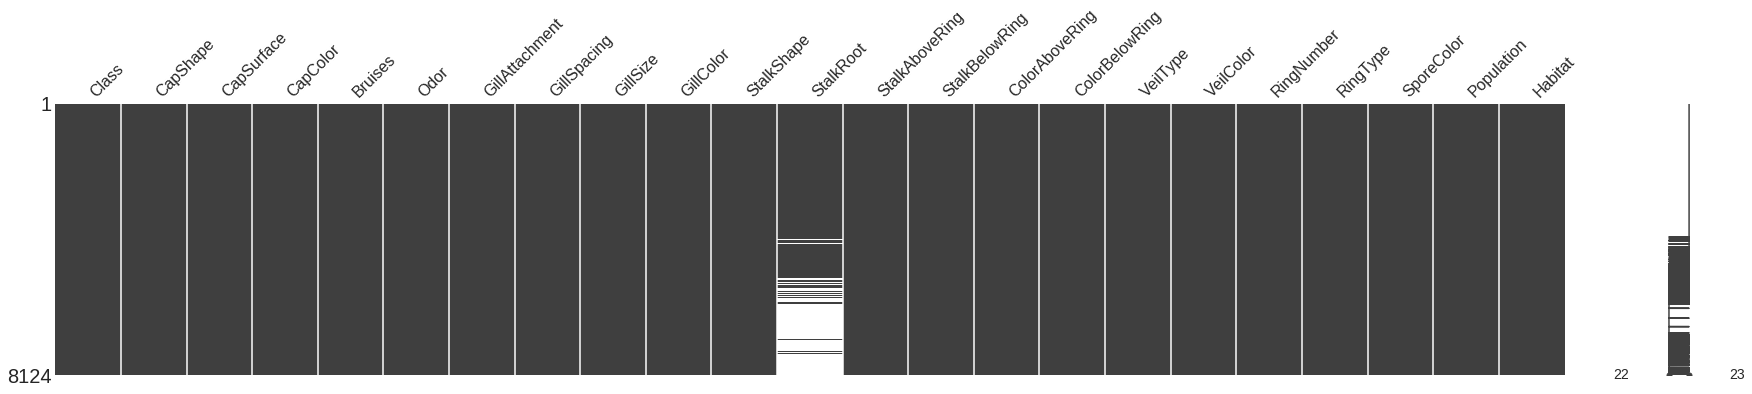

In [14]:
# How many missing values are there in our dataset?
missingno.matrix(dataset_raw, figsize = (30,5))

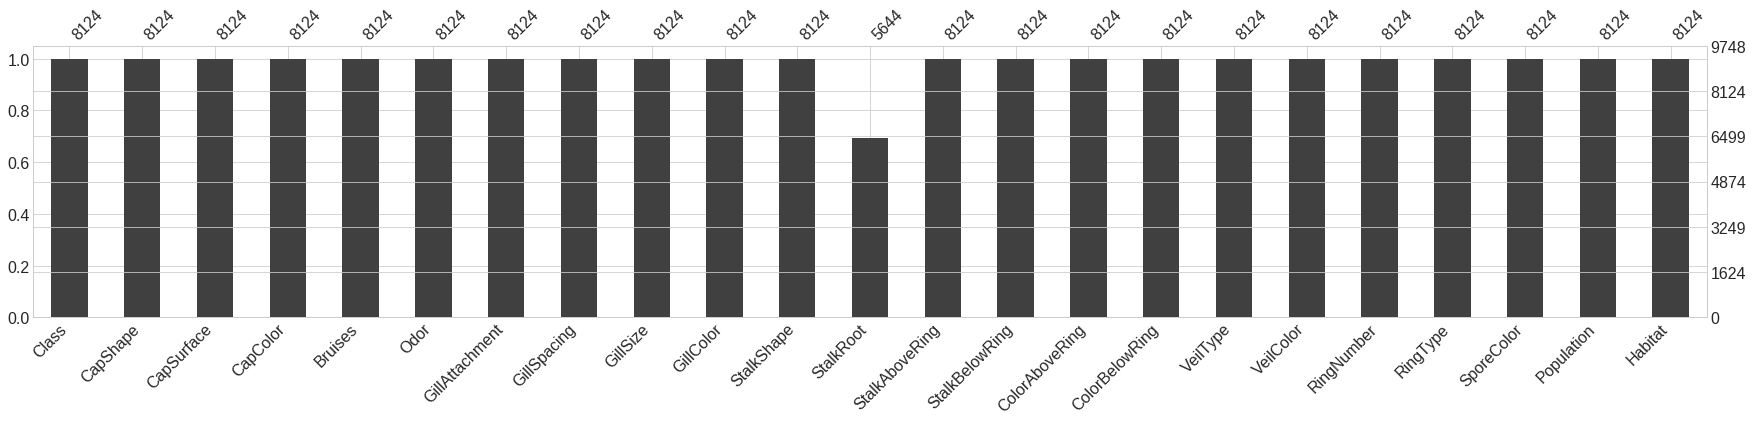

In [15]:
missingno.bar(dataset_raw, sort='ascending', figsize = (30,5))

# Feature Cleaning, Engineering, and Imputation

**Cleaning:**
To clean our data, we'll need to work with:

- **Missing values:** Either omit elements from a dataset that contain missing values or impute them (fill them in).
- **Special values:** Numeric variables are endowed with several formalized special values including ±Inf, NA and NaN. Calculations involving special values often result in special values, and need to be handled/cleaned.
- **Outliers:** They should be detected, but not necessarily removed. Their inclusion in the analysis is a statistical decision.
- **Obvious inconsistencies:** A person's age cannot be negative, a man cannot be pregnant and an under-aged person cannot possess a drivers license. Find the inconsistencies and plan for them.

**Engineering:**
There are multiple techniques for feature engineering:
- **Decompose:** Converting 2014-09-20T20:45:40Z into categorical attributes like hour_of_the_day, part_of_day, etc.
- **Discretization:** We can choose to either discretize some of the continuous variables we have, as some algorithms will perform faster. We are going to do both, and compare the results of the ML algorithms on both discretized and non discretised datasets. We'll call these datasets:

- dataset_bin => where Continuous variables are Discretised
- dataset_con => where Continuous variables are Continuous 

- **Reframe Numerical Quantities:** Changing from grams to kg, and losing detail might be both wanted and efficient for calculation
- **Feature Crossing:** Creating new features as a combination of existing features. Could be multiplying numerical features, or combining categorical variables. This is a great way to add domain expertise knowledge to the dataset.
    
**Imputation:**
We can impute missing values in a number of different ways:
- **Hot-Deck:**	The technique then finds the first missing value and uses the cell value immediately prior to the data that are missing to impute the missing value.
- **Cold-Deck:** Selects donors from another dataset to complete missing data.
- **Mean-substitution:** Another imputation technique involves replacing any missing value with the mean of that variable for all other cases, which has the benefit of not changing the sample mean for that variable.
- **Regression:** A regression model is estimated to predict observed values of a variable based on other variables, and that model is then used to impute values in cases where that variable is missing.

In [16]:
# To perform our data analysis, let's create new dataframes.
dataset_bin = pd.DataFrame() # To contain our dataframe with our discretised continuous variables 


### Feature: Class

This is the feature we are trying to predict. We'll change the string to a binary 0/1. With 1 signifying as edible.

In [17]:
# Let's fix the Class Feature
dataset_raw.loc[dataset_raw['Class'] == 'e', 'Class'] = 1
dataset_raw.loc[dataset_raw['Class'] == 'p', 'Class'] = 0

dataset_bin['Class'] = dataset_raw['Class']

[Text(0,0,'poisonous'), Text(0,0,'edible')]

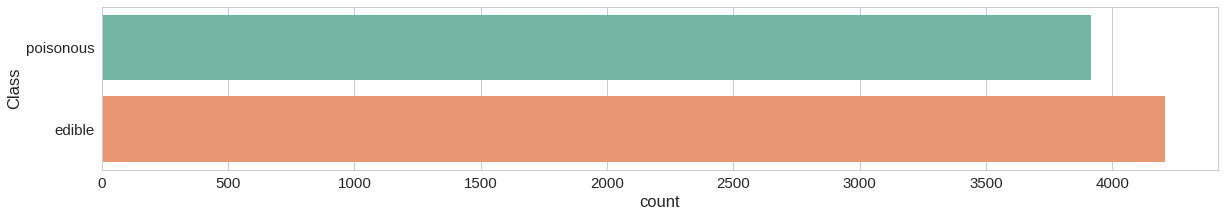

In [18]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,3)) 
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
g = sns.countplot(y="Class", data=dataset_bin, palette="Set2");
g.set_yticklabels(['poisonous','edible'])

### Feature: CapShape

bell=b,conical=c,convex=x,flat=f,knobbed=k,sunken=s

In [19]:

dataset_bin['CapShape'] = dataset_raw['CapShape']

dataset_raw.loc[dataset_raw['CapShape'] == 'b', 'CapShape'] = 'bell'
dataset_raw.loc[dataset_raw['CapShape'] == 'c', 'CapShape'] = 'conical'
dataset_raw.loc[dataset_raw['CapShape'] == 'x', 'CapShape'] = 'convex'
dataset_raw.loc[dataset_raw['CapShape'] == 'f', 'CapShape'] = 'flat'
dataset_raw.loc[dataset_raw['CapShape'] == 'k', 'CapShape'] = 'knobbed'
dataset_raw.loc[dataset_raw['CapShape'] == 's', 'CapShape'] = 'sunken'

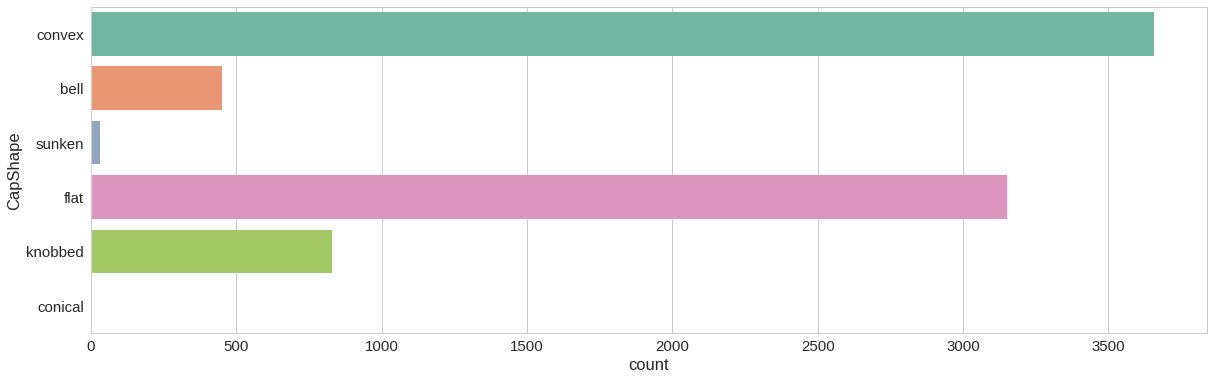

In [20]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,6)) 
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
g = sns.countplot(y="CapShape", data=dataset_raw, palette="Set2");

### Feature: CapSurface

fibrous=f,grooves=g,scaly=y,smooth=s

In [21]:
dataset_bin['CapSurface'] = dataset_raw['CapSurface']

dataset_raw.loc[dataset_raw['CapSurface'] == 'f', 'CapSurface'] = 'fibrous'
dataset_raw.loc[dataset_raw['CapSurface'] == 'g', 'CapSurface'] = 'grooves'
dataset_raw.loc[dataset_raw['CapSurface'] == 'y', 'CapSurface'] = 'scaly'
dataset_raw.loc[dataset_raw['CapSurface'] == 's', 'CapSurface'] = 'smooth'

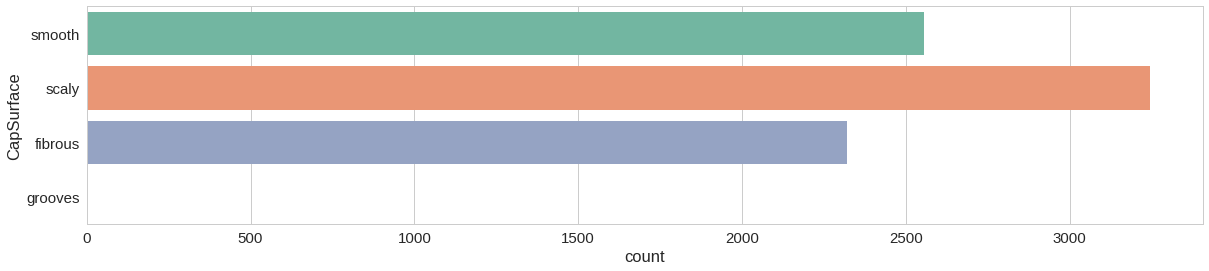

In [22]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,4)) 
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
g = sns.countplot(y="CapSurface", data=dataset_raw, palette="Set2");


### Feature: CapColor

brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y

In [23]:
dataset_bin['CapColor'] = dataset_raw['CapColor']

dataset_raw.loc[dataset_raw['CapColor'] == 'n', 'CapColor'] = 'brown'
dataset_raw.loc[dataset_raw['CapColor'] == 'b', 'CapColor'] = 'buff'
dataset_raw.loc[dataset_raw['CapColor'] == 'c', 'CapColor'] = 'cinnamon'
dataset_raw.loc[dataset_raw['CapColor'] == 'g', 'CapColor'] = 'gray'
dataset_raw.loc[dataset_raw['CapColor'] == 'r', 'CapColor'] = 'green'
dataset_raw.loc[dataset_raw['CapColor'] == 'p', 'CapColor'] = 'pink'
dataset_raw.loc[dataset_raw['CapColor'] == 'u', 'CapColor'] = 'purple'
dataset_raw.loc[dataset_raw['CapColor'] == 'e', 'CapColor'] = 'red'
dataset_raw.loc[dataset_raw['CapColor'] == 'w', 'CapColor'] = 'white'
dataset_raw.loc[dataset_raw['CapColor'] == 'y', 'CapColor'] = 'yellow'

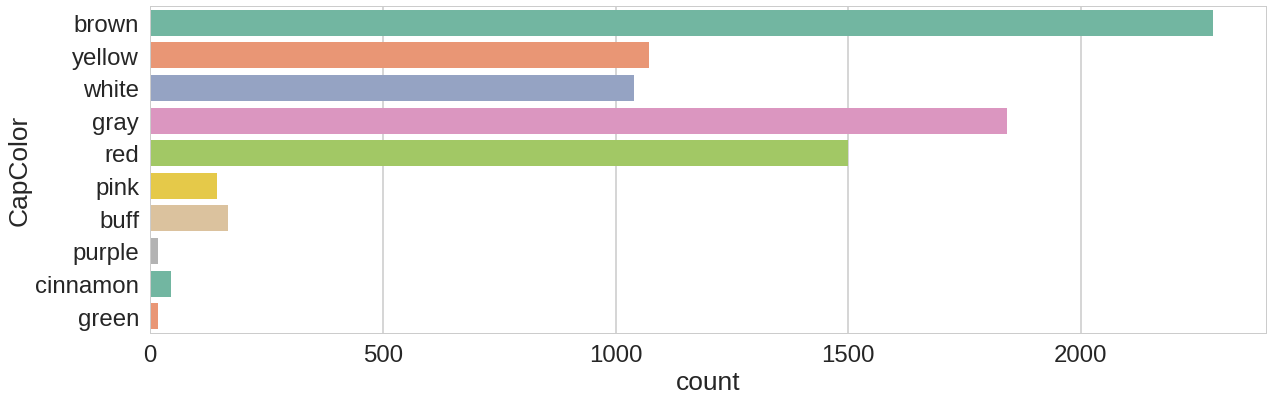

In [24]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,6)) 
sns.set_context("poster", font_scale=1.5, rc={"lines.linewidth": 2.5})
g = sns.countplot(y="CapColor", data=dataset_raw, palette="Set2");


### Feature: Bruises

bruises=t,no=f

In [66]:
dataset_bin['Bruises'] = dataset_raw['Bruises']
dataset_raw.loc[dataset_raw['Bruises'] == 't', 'Bruises'] = 'bruises'
dataset_raw.loc[dataset_raw['Bruises'] == 'f', 'Bruises'] = 'noBrusies'

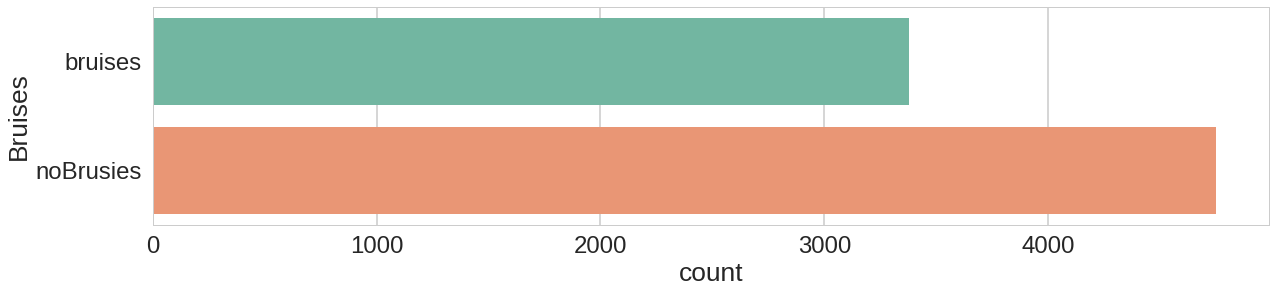

In [67]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,4)) 
sns.set_context("poster", font_scale=1.5, rc={"lines.linewidth": 2.5})
g = sns.countplot(y="Bruises", data=dataset_raw, palette="Set2");

### Feature: Odor

almond=a,anise=l,creosote=c,fishy=y,foul=f,musty=m,none=n,pungent=p,spicy=s

In [27]:
dataset_bin['Odor'] = dataset_raw['Odor']

dataset_raw.loc[dataset_raw['Odor'] == 'a', 'Odor'] = 'almond'
dataset_raw.loc[dataset_raw['Odor'] == 'l', 'Odor'] = 'anise'
dataset_raw.loc[dataset_raw['Odor'] == 'c', 'Odor'] = 'creosote'
dataset_raw.loc[dataset_raw['Odor'] == 'y', 'Odor'] = 'fishy'
dataset_raw.loc[dataset_raw['Odor'] == 'f', 'Odor'] = 'foul'
dataset_raw.loc[dataset_raw['Odor'] == 'm', 'Odor'] = 'musty'
dataset_raw.loc[dataset_raw['Odor'] == 'n', 'Odor'] = 'none'
dataset_raw.loc[dataset_raw['Odor'] == 'p', 'Odor'] = 'pungent'
dataset_raw.loc[dataset_raw['Odor'] == 's', 'Odor'] = 'spicy'

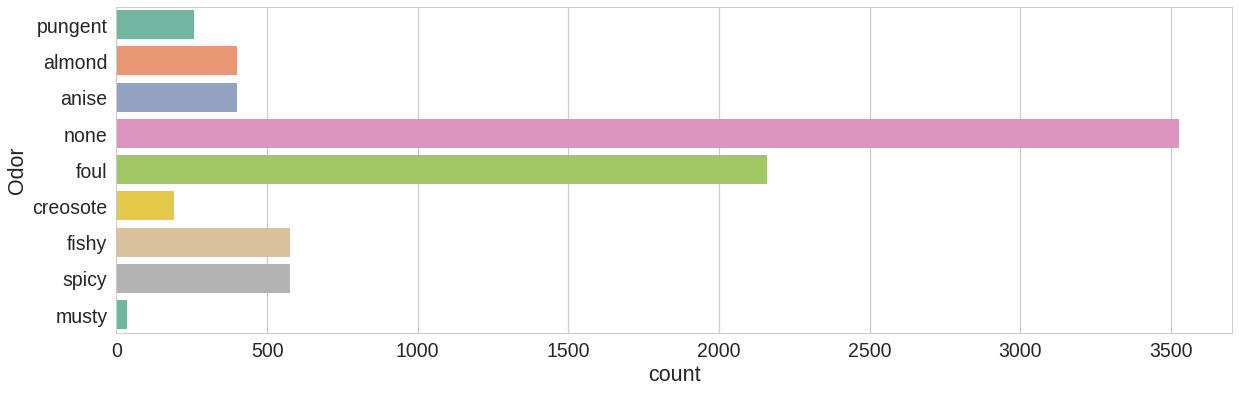

In [28]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,6)) 
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})
g = sns.countplot(y="Odor", data=dataset_raw, palette="Set2");


### Feature: GillAttachment

attached=a,descending=d,free=f,notched=n

In [29]:
dataset_bin['GillAttachment'] = dataset_raw['GillAttachment']

dataset_raw.loc[dataset_raw['GillAttachment'] == 'a', 'GillAttachment'] = 'attached'
dataset_raw.loc[dataset_raw['GillAttachment'] == 'd', 'GillAttachment'] = 'descending'
dataset_raw.loc[dataset_raw['GillAttachment'] == 'f', 'GillAttachment'] = 'free'
dataset_raw.loc[dataset_raw['GillAttachment'] == 'n', 'GillAttachment'] = 'notched'

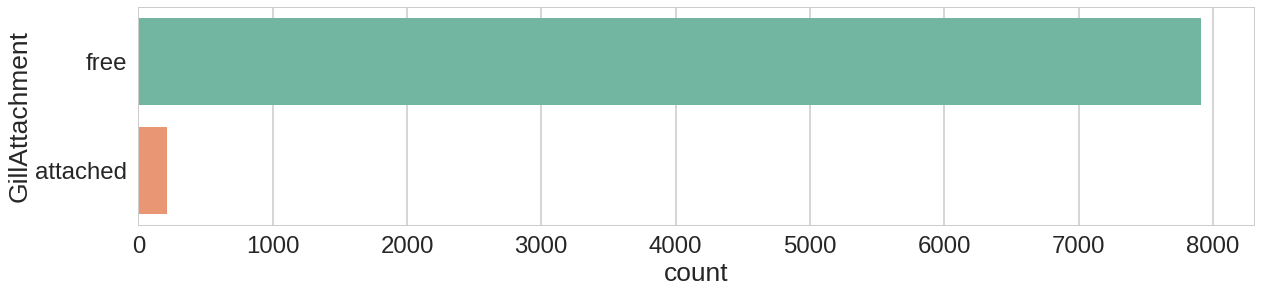

In [30]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,4)) 
sns.set_context("poster", font_scale=1.5, rc={"lines.linewidth": 2.5})
g = sns.countplot(y="GillAttachment", data=dataset_raw, palette="Set2");


### Feature: GillSpacing

close=c,crowded=w,distant=d

In [31]:
dataset_bin['GillSpacing'] = dataset_raw['GillSpacing']
dataset_raw.loc[dataset_raw['GillSpacing'] == 'c', 'GillSpacing'] = 'close'
dataset_raw.loc[dataset_raw['GillSpacing'] == 'w', 'GillSpacing'] = 'crowded'
dataset_raw.loc[dataset_raw['GillSpacing'] == 'd', 'GillSpacing'] = 'distant'

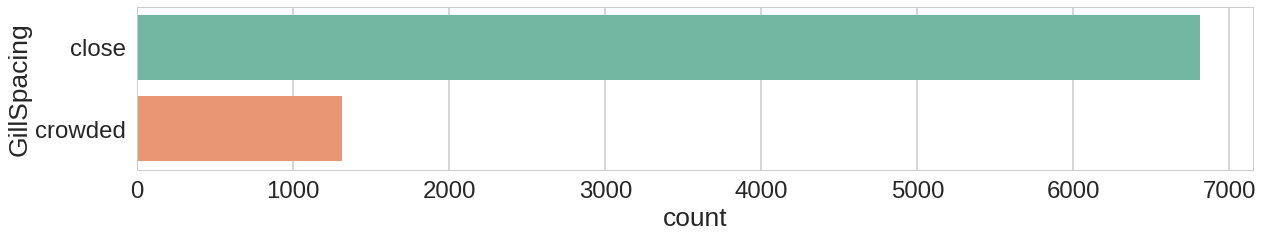

In [32]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,3)) 
sns.set_context("poster", font_scale=1.5, rc={"lines.linewidth": 2.5})
g = sns.countplot(y="GillSpacing", data=dataset_raw, palette="Set2");


### Feature: GillSize

broad=b,narrow=n

In [33]:
dataset_bin['GillSize'] = dataset_raw['GillSize']
dataset_raw.loc[dataset_raw['GillSize'] == 'b', 'GillSize'] = 'broad'
dataset_raw.loc[dataset_raw['GillSize'] == 'n', 'GillSize'] = 'narrow'

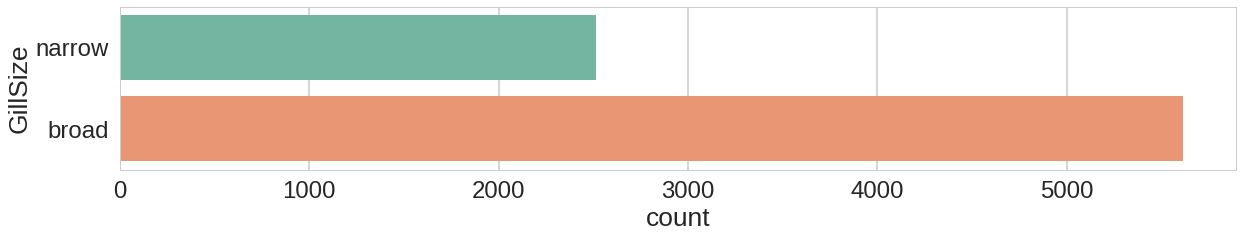

In [34]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,3)) 
sns.set_context("poster", font_scale=1.5, rc={"lines.linewidth": 2.5})
g = sns.countplot(y="GillSize", data=dataset_raw, palette="Set2");

### Feature: GillColor

black=k,brown=n,buff=b,chocolate=h,gray=g,
                                  green=r,orange=o,pink=p,purple=u,red=e,
                                  white=w,yellow=y

In [35]:
dataset_bin['GillColor'] = dataset_raw['GillColor']
dataset_raw.loc[dataset_raw['GillColor'] == 'k', 'GillColor'] = 'black'
dataset_raw.loc[dataset_raw['GillColor'] == 'n', 'GillColor'] = 'brown'
dataset_raw.loc[dataset_raw['GillColor'] == 'b', 'GillColor'] = 'buff'
dataset_raw.loc[dataset_raw['GillColor'] == 'h', 'GillColor'] = 'chocolate'
dataset_raw.loc[dataset_raw['GillColor'] == 'g', 'GillColor'] = 'gray'
dataset_raw.loc[dataset_raw['GillColor'] == 'r', 'GillColor'] = 'green'
dataset_raw.loc[dataset_raw['GillColor'] == 'o', 'GillColor'] = 'orange'
dataset_raw.loc[dataset_raw['GillColor'] == 'p', 'GillColor'] = 'pink'
dataset_raw.loc[dataset_raw['GillColor'] == 'u', 'GillColor'] = 'purple'
dataset_raw.loc[dataset_raw['GillColor'] == 'e', 'GillColor'] = 'red'
dataset_raw.loc[dataset_raw['GillColor'] == 'w', 'GillColor'] = 'white'
dataset_raw.loc[dataset_raw['GillColor'] == 'y', 'GillColor'] = 'yellow'

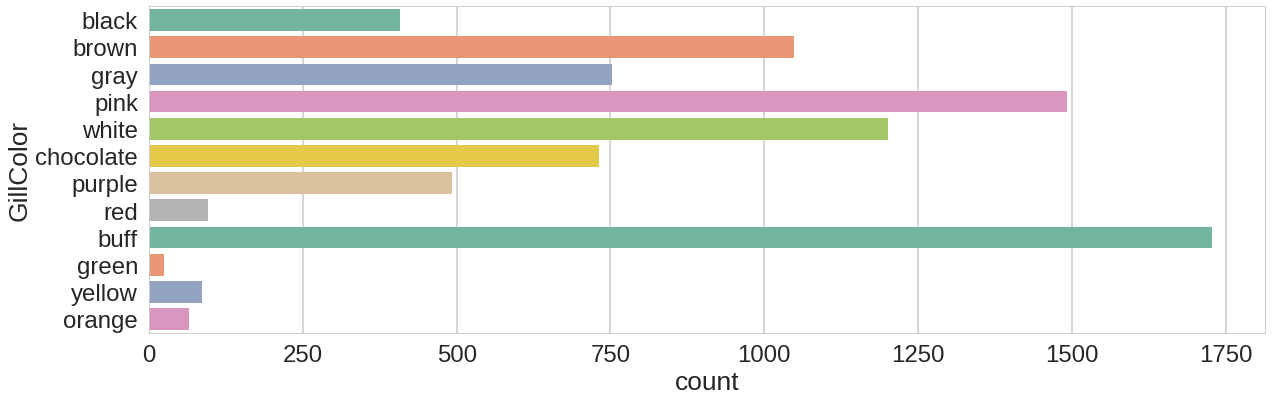

In [36]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,6)) 
sns.set_context("poster", font_scale=1.5, rc={"lines.linewidth": 2.5})
g = sns.countplot(y="GillColor", data=dataset_raw, palette="Set2");


### Feature: StalkShape

enlarging=e,tapering=t

In [37]:
dataset_bin['StalkShape'] = dataset_raw['StalkShape']
dataset_raw.loc[dataset_raw['StalkShape'] == 'e', 'StalkShape'] = 'enlarging'
dataset_raw.loc[dataset_raw['StalkShape'] == 't', 'StalkShape'] = 'tapering'

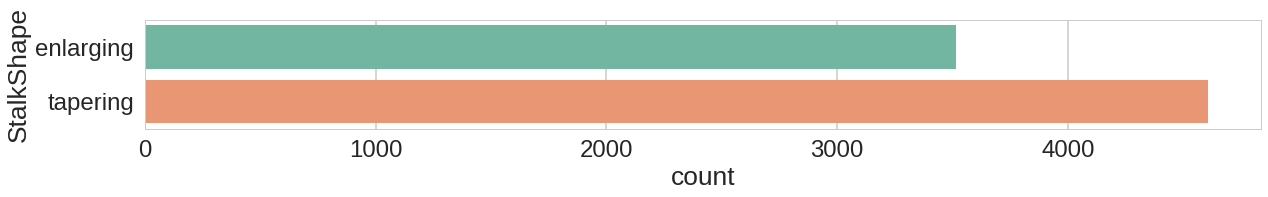

In [38]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,2)) 
sns.set_context("poster", font_scale=1.5, rc={"lines.linewidth": 2.5})
g = sns.countplot(y="StalkShape", data=dataset_raw, palette="Set2");


### Feature: StalkRoot

bulbous=b,club=c,cup=u,equal=e,
                                  rhizomorphs=z,rooted=r,missing=?

In [39]:
dataset_bin['StalkRoot'] = dataset_raw['StalkRoot']
dataset_raw.loc[dataset_raw['StalkRoot'] == 'b', 'StalkRoot'] = 'bulbous'
dataset_raw.loc[dataset_raw['StalkRoot'] == 'c', 'StalkRoot'] = 'club'
dataset_raw.loc[dataset_raw['StalkRoot'] == 'u', 'StalkRoot'] = 'cup'
dataset_raw.loc[dataset_raw['StalkRoot'] == 'e', 'StalkRoot'] = 'equal'
dataset_raw.loc[dataset_raw['StalkRoot'] == 'z', 'StalkRoot'] = 'rhizomorphs'
dataset_raw.loc[dataset_raw['StalkRoot'] == 'r', 'StalkRoot'] = 'rooted'
dataset_raw.loc[dataset_raw['StalkRoot'] == '?', 'StalkRoot'] = 'missing'

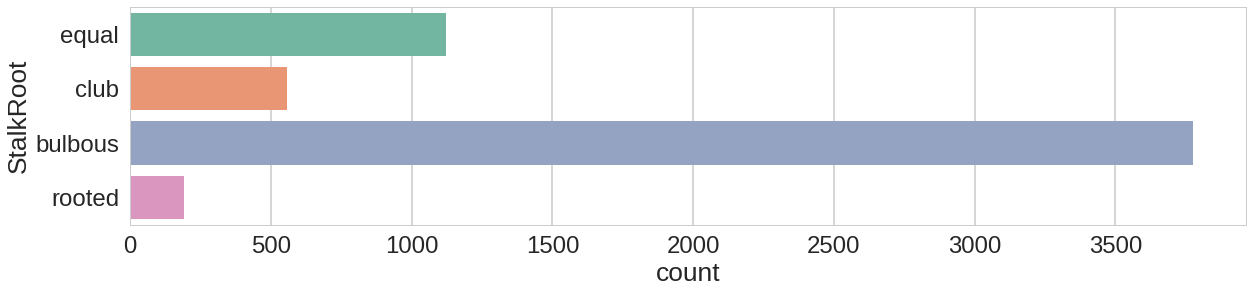

In [40]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,4)) 
sns.set_context("poster", font_scale=1.5, rc={"lines.linewidth": 2.5})
g = sns.countplot(y="StalkRoot", data=dataset_raw, palette="Set2");


### Feature: StalkAboveRing

fibrous=f,scaly=y,silky=k,smooth=s

In [41]:
dataset_bin['StalkAboveRing'] = dataset_raw['StalkAboveRing']
dataset_raw.loc[dataset_raw['StalkAboveRing'] == 'f', 'StalkAboveRing'] = 'fibrous'
dataset_raw.loc[dataset_raw['StalkAboveRing'] == 'y', 'StalkAboveRing'] = 'scaly'
dataset_raw.loc[dataset_raw['StalkAboveRing'] == 'k', 'StalkAboveRing'] = 'silky'
dataset_raw.loc[dataset_raw['StalkAboveRing'] == 's', 'StalkAboveRing'] = 'smooth'

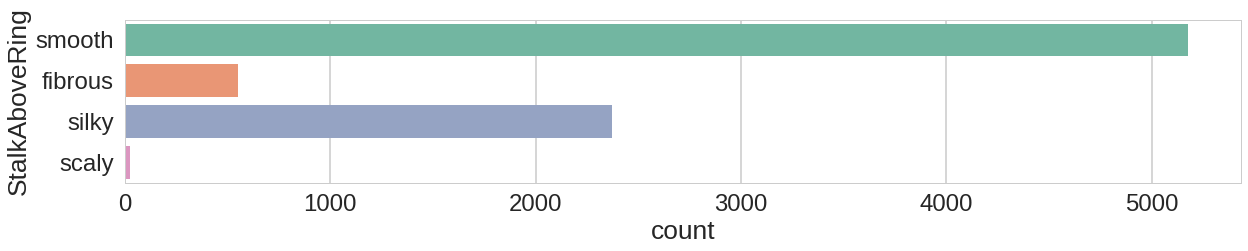

In [42]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,3)) 
sns.set_context("poster", font_scale=1.5, rc={"lines.linewidth": 2.5})
g = sns.countplot(y="StalkAboveRing", data=dataset_raw, palette="Set2");


### Feature: StalkBelowRing

fibrous=f,scaly=y,silky=k,smooth=s

In [43]:
dataset_bin['StalkBelowRing'] = dataset_raw['StalkBelowRing']
dataset_raw.loc[dataset_raw['StalkBelowRing'] == 'f', 'StalkBelowRing'] = 'fibrous'
dataset_raw.loc[dataset_raw['StalkBelowRing'] == 'y', 'StalkBelowRing'] = 'scaly'
dataset_raw.loc[dataset_raw['StalkBelowRing'] == 'k', 'StalkBelowRing'] = 'silky'
dataset_raw.loc[dataset_raw['StalkBelowRing'] == 's', 'StalkBelowRing'] = 'smooth'

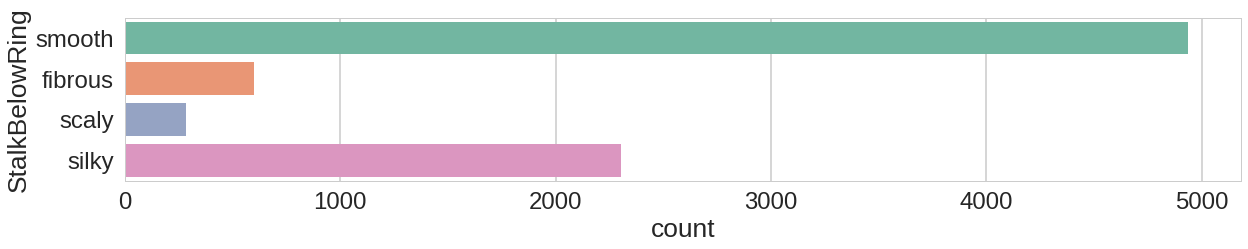

In [44]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,3)) 
sns.set_context("poster", font_scale=1.5, rc={"lines.linewidth": 2.5})
g = sns.countplot(y="StalkBelowRing", data=dataset_raw, palette="Set2");

### Feature: ColorAboveRing

brown=n,buff=b,cinnamon=c,gray=g,orange=o,
                                  pink=p,red=e,white=w,yellow=y

In [45]:
dataset_bin['ColorAboveRing'] = dataset_raw['ColorAboveRing']
dataset_raw.loc[dataset_raw['ColorAboveRing'] == 'n', 'ColorAboveRing'] = 'brown'
dataset_raw.loc[dataset_raw['ColorAboveRing'] == 'b', 'ColorAboveRing'] = 'buff'
dataset_raw.loc[dataset_raw['ColorAboveRing'] == 'c', 'ColorAboveRing'] = 'cinnamon'
dataset_raw.loc[dataset_raw['ColorAboveRing'] == 'g', 'ColorAboveRing'] = 'gray'
dataset_raw.loc[dataset_raw['ColorAboveRing'] == 'o', 'ColorAboveRing'] = 'orange'
dataset_raw.loc[dataset_raw['ColorAboveRing'] == 'p', 'ColorAboveRing'] = 'pink'
dataset_raw.loc[dataset_raw['ColorAboveRing'] == 'e', 'ColorAboveRing'] = 'red'
dataset_raw.loc[dataset_raw['ColorAboveRing'] == 'w', 'ColorAboveRing'] = 'white'
dataset_raw.loc[dataset_raw['ColorAboveRing'] == 'y', 'ColorAboveRing'] = 'yellow'

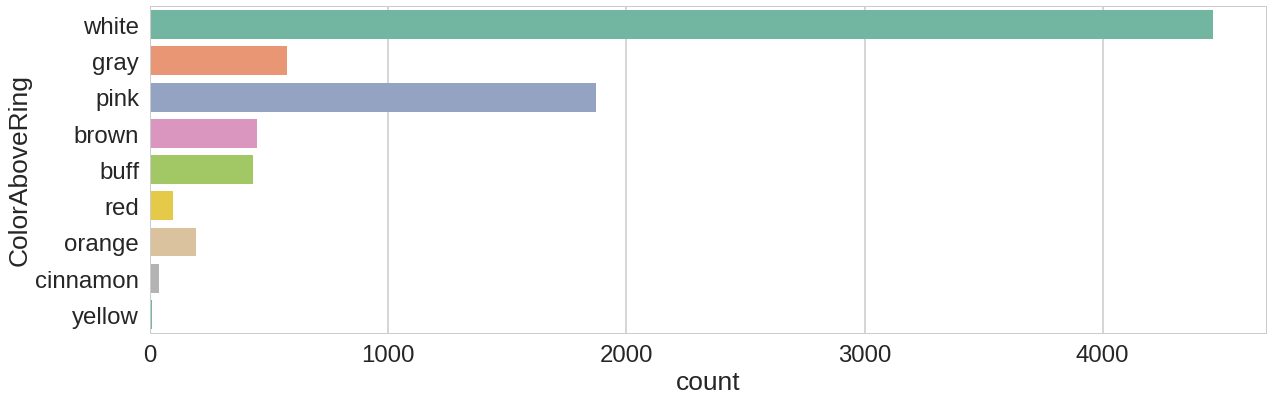

In [46]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,6)) 
sns.set_context("poster", font_scale=1.5, rc={"lines.linewidth": 2.5})
g = sns.countplot(y="ColorAboveRing", data=dataset_raw, palette="Set2");


### Feature: ColorBelowRing

brown=n,buff=b,cinnamon=c,gray=g,orange=o,
                                  pink=p,red=e,white=w,yellow=y

In [47]:
dataset_bin['ColorBelowRing'] = dataset_raw['ColorBelowRing']
dataset_raw.loc[dataset_raw['ColorBelowRing'] == 'n', 'ColorBelowRing'] = 'brown'
dataset_raw.loc[dataset_raw['ColorBelowRing'] == 'b', 'ColorBelowRing'] = 'buff'
dataset_raw.loc[dataset_raw['ColorBelowRing'] == 'c', 'ColorBelowRing'] = 'cinnamon'
dataset_raw.loc[dataset_raw['ColorBelowRing'] == 'g', 'ColorBelowRing'] = 'gray'
dataset_raw.loc[dataset_raw['ColorBelowRing'] == 'o', 'ColorBelowRing'] = 'orange'
dataset_raw.loc[dataset_raw['ColorBelowRing'] == 'p', 'ColorBelowRing'] = 'pink'
dataset_raw.loc[dataset_raw['ColorBelowRing'] == 'e', 'ColorBelowRing'] = 'red'
dataset_raw.loc[dataset_raw['ColorBelowRing'] == 'w', 'ColorBelowRing'] = 'white'
dataset_raw.loc[dataset_raw['ColorBelowRing'] == 'y', 'ColorBelowRing'] = 'yellow'

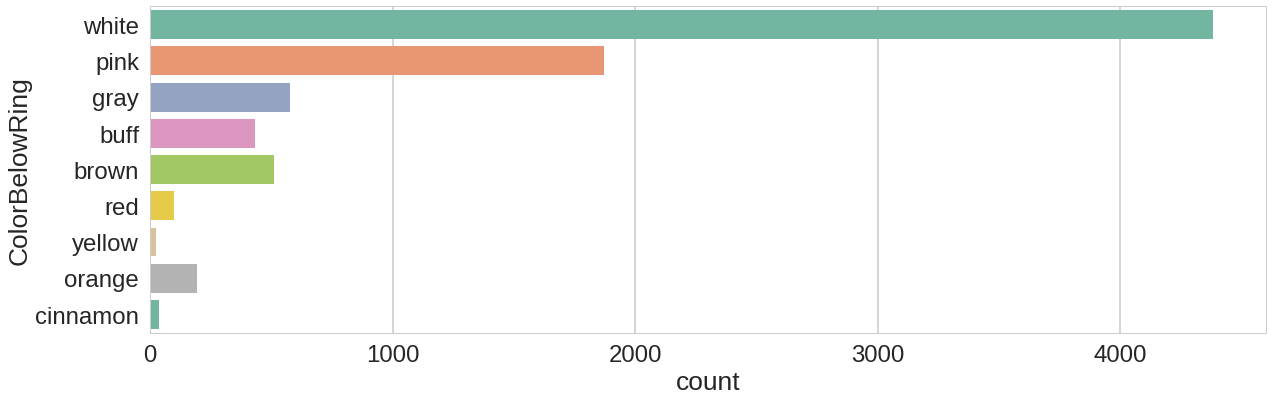

In [48]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,6)) 
sns.set_context("poster", font_scale=1.5, rc={"lines.linewidth": 2.5})
g = sns.countplot(y="ColorBelowRing", data=dataset_raw, palette="Set2");


### Feature: VeilType

partial=p,universal=u

In [49]:
dataset_bin['VeilType'] = dataset_raw['VeilType']
dataset_raw.loc[dataset_raw['VeilType'] == 'p', 'VeilType'] = 'partial'
dataset_raw.loc[dataset_raw['VeilType'] == 'u', 'VeilType'] = 'universal'

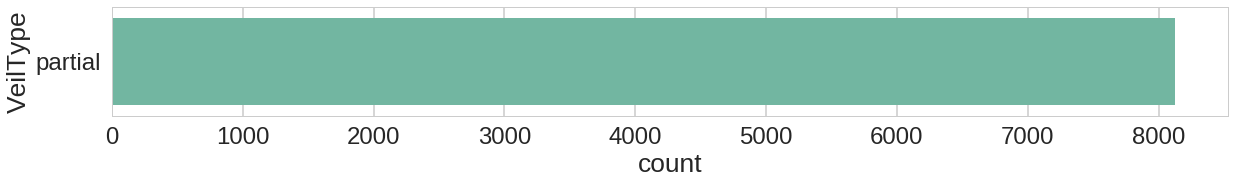

In [50]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,2)) 
sns.set_context("poster", font_scale=1.5, rc={"lines.linewidth": 2.5})
g = sns.countplot(y="VeilType", data=dataset_raw, palette="Set2");


### Feature: VeilColor

brown=n,orange=o,white=w,yellow=y

In [51]:
dataset_bin['VeilColor'] = dataset_raw['VeilColor']
dataset_raw.loc[dataset_raw['VeilColor'] == 'n', 'VeilColor'] = 'brown'
dataset_raw.loc[dataset_raw['VeilColor'] == 'o', 'VeilColor'] = 'orange'
dataset_raw.loc[dataset_raw['VeilColor'] == 'w', 'VeilColor'] = 'white'
dataset_raw.loc[dataset_raw['VeilColor'] == 'y', 'VeilColor'] = 'yellow'

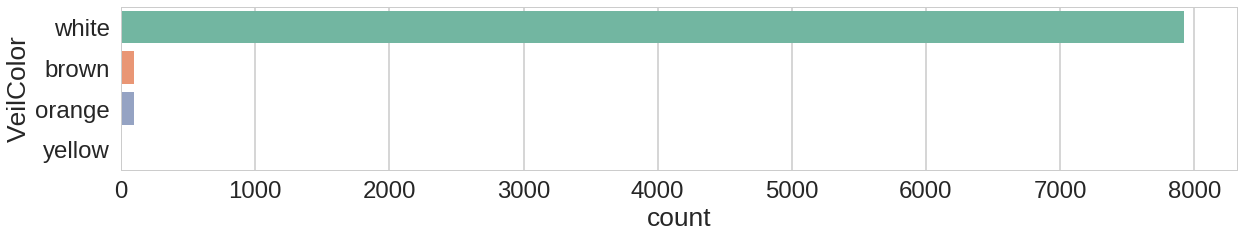

In [52]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,3)) 
sns.set_context("poster", font_scale=1.5, rc={"lines.linewidth": 2.5})
g = sns.countplot(y="VeilColor", data=dataset_raw, palette="Set2");


### Feature: RingNumber

none=n,one=o,two=t

In [53]:
dataset_bin['RingNumber'] = dataset_raw['RingNumber']
dataset_raw.loc[dataset_raw['RingNumber'] == 'n', 'RingNumber'] = 'none'
dataset_raw.loc[dataset_raw['RingNumber'] == 'o', 'RingNumber'] = 'one'
dataset_raw.loc[dataset_raw['RingNumber'] == 't', 'RingNumber'] = 'two'

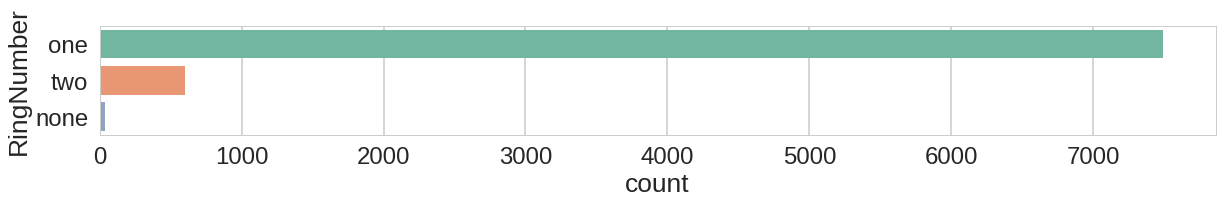

In [54]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,2)) 
sns.set_context("poster", font_scale=1.5, rc={"lines.linewidth": 2.5})
g = sns.countplot(y="RingNumber", data=dataset_raw, palette="Set2");


### Feature: RingType

cobwebby=c,evanescent=e,flaring=f,large=l,
                                  none=n,pendant=p,sheathing=s,zone=z

In [55]:
dataset_bin['RingType'] = dataset_raw['RingType']
dataset_raw.loc[dataset_raw['RingType'] == 'c', 'RingType'] = 'cobwebby'
dataset_raw.loc[dataset_raw['RingType'] == 'e', 'RingType'] = 'evanescent'
dataset_raw.loc[dataset_raw['RingType'] == 'f', 'RingType'] = 'flaring'
dataset_raw.loc[dataset_raw['RingType'] == 'l', 'RingType'] = 'large'
dataset_raw.loc[dataset_raw['RingType'] == 'n', 'RingType'] = 'none'
dataset_raw.loc[dataset_raw['RingType'] == 'p', 'RingType'] = 'pendant'
dataset_raw.loc[dataset_raw['RingType'] == 's', 'RingType'] = 'sheathing'
dataset_raw.loc[dataset_raw['RingType'] == 'z', 'RingType'] = 'zone'

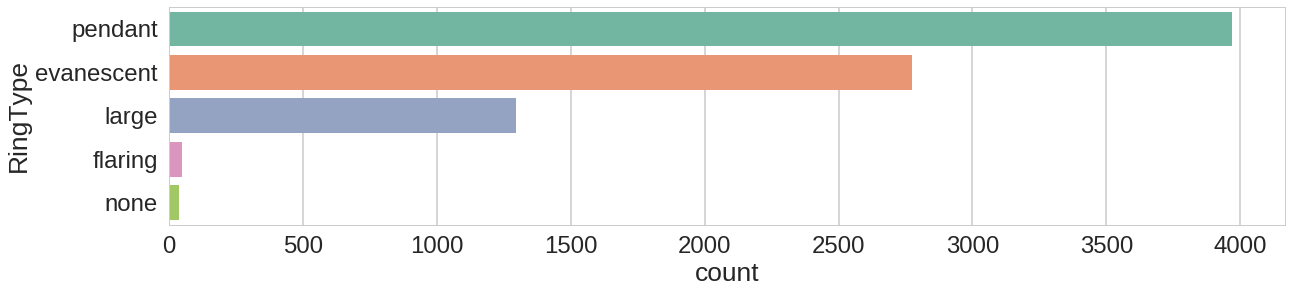

In [56]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,4)) 
sns.set_context("poster", font_scale=1.5, rc={"lines.linewidth": 2.5})
g = sns.countplot(y="RingType", data=dataset_raw, palette="Set2");

### Feature: SporeColor

black=k,brown=n,buff=b,chocolate=h,green=r,
                                  orange=o,purple=u,white=w,yellow=y

In [57]:
dataset_bin['SporeColor'] = dataset_raw['SporeColor']
dataset_raw.loc[dataset_raw['SporeColor'] == 'k', 'SporeColor'] = 'black'
dataset_raw.loc[dataset_raw['SporeColor'] == 'n', 'SporeColor'] = 'brown'
dataset_raw.loc[dataset_raw['SporeColor'] == 'b', 'SporeColor'] = 'buff'
dataset_raw.loc[dataset_raw['SporeColor'] == 'h', 'SporeColor'] = 'chocolate'
dataset_raw.loc[dataset_raw['SporeColor'] == 'r', 'SporeColor'] = 'green'
dataset_raw.loc[dataset_raw['SporeColor'] == 'o', 'SporeColor'] = 'orange'
dataset_raw.loc[dataset_raw['SporeColor'] == 'u', 'SporeColor'] = 'purple'
dataset_raw.loc[dataset_raw['SporeColor'] == 'w', 'SporeColor'] = 'white'
dataset_raw.loc[dataset_raw['SporeColor'] == 'y', 'SporeColor'] = 'yellow'

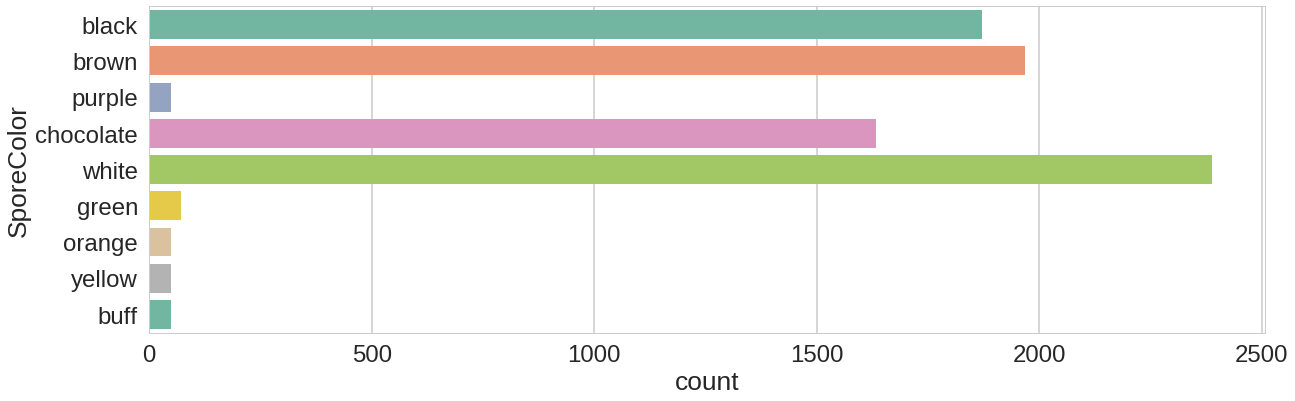

In [58]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,6)) 
sns.set_context("poster", font_scale=1.5, rc={"lines.linewidth": 2.5})
g = sns.countplot(y="SporeColor", data=dataset_raw, palette="Set2");


### Feature: Population

abundant=a,clustered=c,numerous=n,
                                  scattered=s,several=v,solitary=y

In [59]:
dataset_bin['Population'] = dataset_raw['Population']
dataset_raw.loc[dataset_raw['Population'] == 'a', 'Population'] = 'abundant'
dataset_raw.loc[dataset_raw['Population'] == 'c', 'Population'] = 'clustered'
dataset_raw.loc[dataset_raw['Population'] == 'n', 'Population'] = 'numerous'
dataset_raw.loc[dataset_raw['Population'] == 's', 'Population'] = 'scattered'
dataset_raw.loc[dataset_raw['Population'] == 'v', 'Population'] = 'several'
dataset_raw.loc[dataset_raw['Population'] == 'y', 'Population'] = 'solitary'

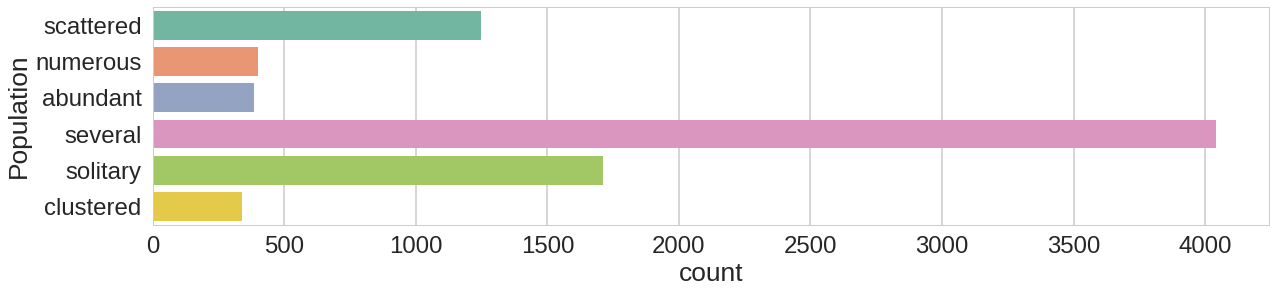

In [60]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,4)) 
sns.set_context("poster", font_scale=1.5, rc={"lines.linewidth": 2.5})
g = sns.countplot(y="Population", data=dataset_raw, palette="Set2");


### Feature: Habitat

grasses=g,leaves=l,meadows=m,paths=p,
                                  urban=u,waste=w,woods=d

In [61]:
dataset_bin['Habitat'] = dataset_raw['Habitat']
dataset_raw.loc[dataset_raw['Habitat'] == 'g', 'Habitat'] = 'grasses'
dataset_raw.loc[dataset_raw['Habitat'] == 'l', 'Habitat'] = 'leaves'
dataset_raw.loc[dataset_raw['Habitat'] == 'm', 'Habitat'] = 'meadows'
dataset_raw.loc[dataset_raw['Habitat'] == 'p', 'Habitat'] = 'paths'
dataset_raw.loc[dataset_raw['Habitat'] == 'u', 'Habitat'] = 'urban'
dataset_raw.loc[dataset_raw['Habitat'] == 'w', 'Habitat'] = 'waste'
dataset_raw.loc[dataset_raw['Habitat'] == 'd', 'Habitat'] = 'woods'

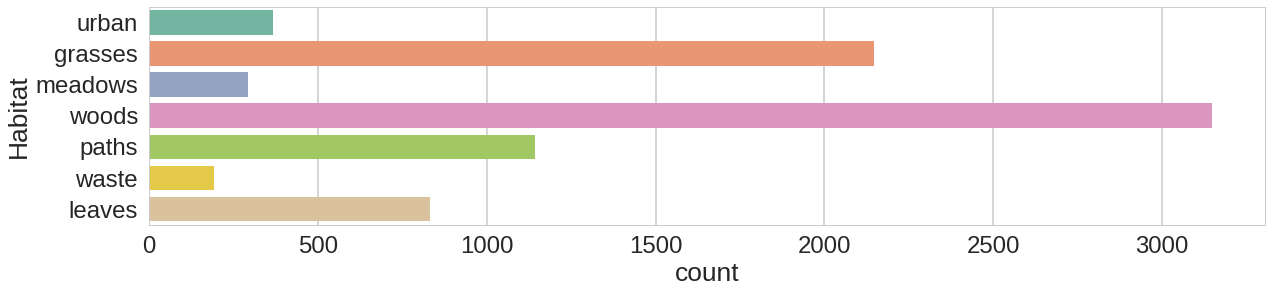

In [62]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,4)) 
sns.set_context("poster", font_scale=1.5, rc={"lines.linewidth": 2.5})
g = sns.countplot(y="Habitat", data=dataset_raw, palette="Set2");


In [63]:
dataset_bin.head()

,Class,CapShape,CapSurface,CapColor,Bruises,Odor,GillAttachment,GillSpacing,GillSize,GillColor,...,StalkBelowRing,ColorAboveRing,ColorBelowRing,VeilType,VeilColor,RingNumber,RingType,SporeColor,Population,Habitat
0,0,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,1,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,1,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,0,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,1,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [68]:
dataset_raw.head(20)

,Class,CapShape,CapSurface,CapColor,Bruises,Odor,GillAttachment,GillSpacing,GillSize,GillColor,...,StalkBelowRing,ColorAboveRing,ColorBelowRing,VeilType,VeilColor,RingNumber,RingType,SporeColor,Population,Habitat
0,0,convex,smooth,brown,bruises,pungent,free,close,narrow,black,...,smooth,white,white,partial,white,one,pendant,black,scattered,urban
1,1,convex,smooth,yellow,bruises,almond,free,close,broad,black,...,smooth,white,white,partial,white,one,pendant,brown,numerous,grasses
2,1,bell,smooth,white,bruises,anise,free,close,broad,brown,...,smooth,white,white,partial,white,one,pendant,brown,numerous,meadows
3,0,convex,scaly,white,bruises,pungent,free,close,narrow,brown,...,smooth,white,white,partial,white,one,pendant,black,scattered,urban
4,1,convex,smooth,gray,noBrusies,none,free,crowded,broad,black,...,smooth,white,white,partial,white,one,evanescent,brown,abundant,grasses
5,1,convex,scaly,yellow,bruises,almond,free,close,broad,brown,...,smooth,white,white,partial,white,one,pendant,black,numerous,grasses
6,1,bell,smooth,white,bruises,almond,free,close,broad,gray,...,smooth,white,white,partial,white,one,pendant,black,numerous,meadows
7,1,bell,scaly,white,bruises,anise,free,close,broad,brown,...,smooth,white,white,partial,white,one,pendant,brown,scattered,meadows
8,0,convex,scaly,white,bruises,pungent,free,close,narrow,pink,...,smooth,white,white,partial,white,one,pendant,black,several,grasses
9,1,bell,smooth,yellow,bruises,almond,free,close,broad,gray,...,smooth,white,white,partial,white,one,pendant,black,scattered,meadows


## Bi-variate Analysis

So far, we have analised all features individually. Let's now start combining some of these features together to obtain further insight into the interactions between them.

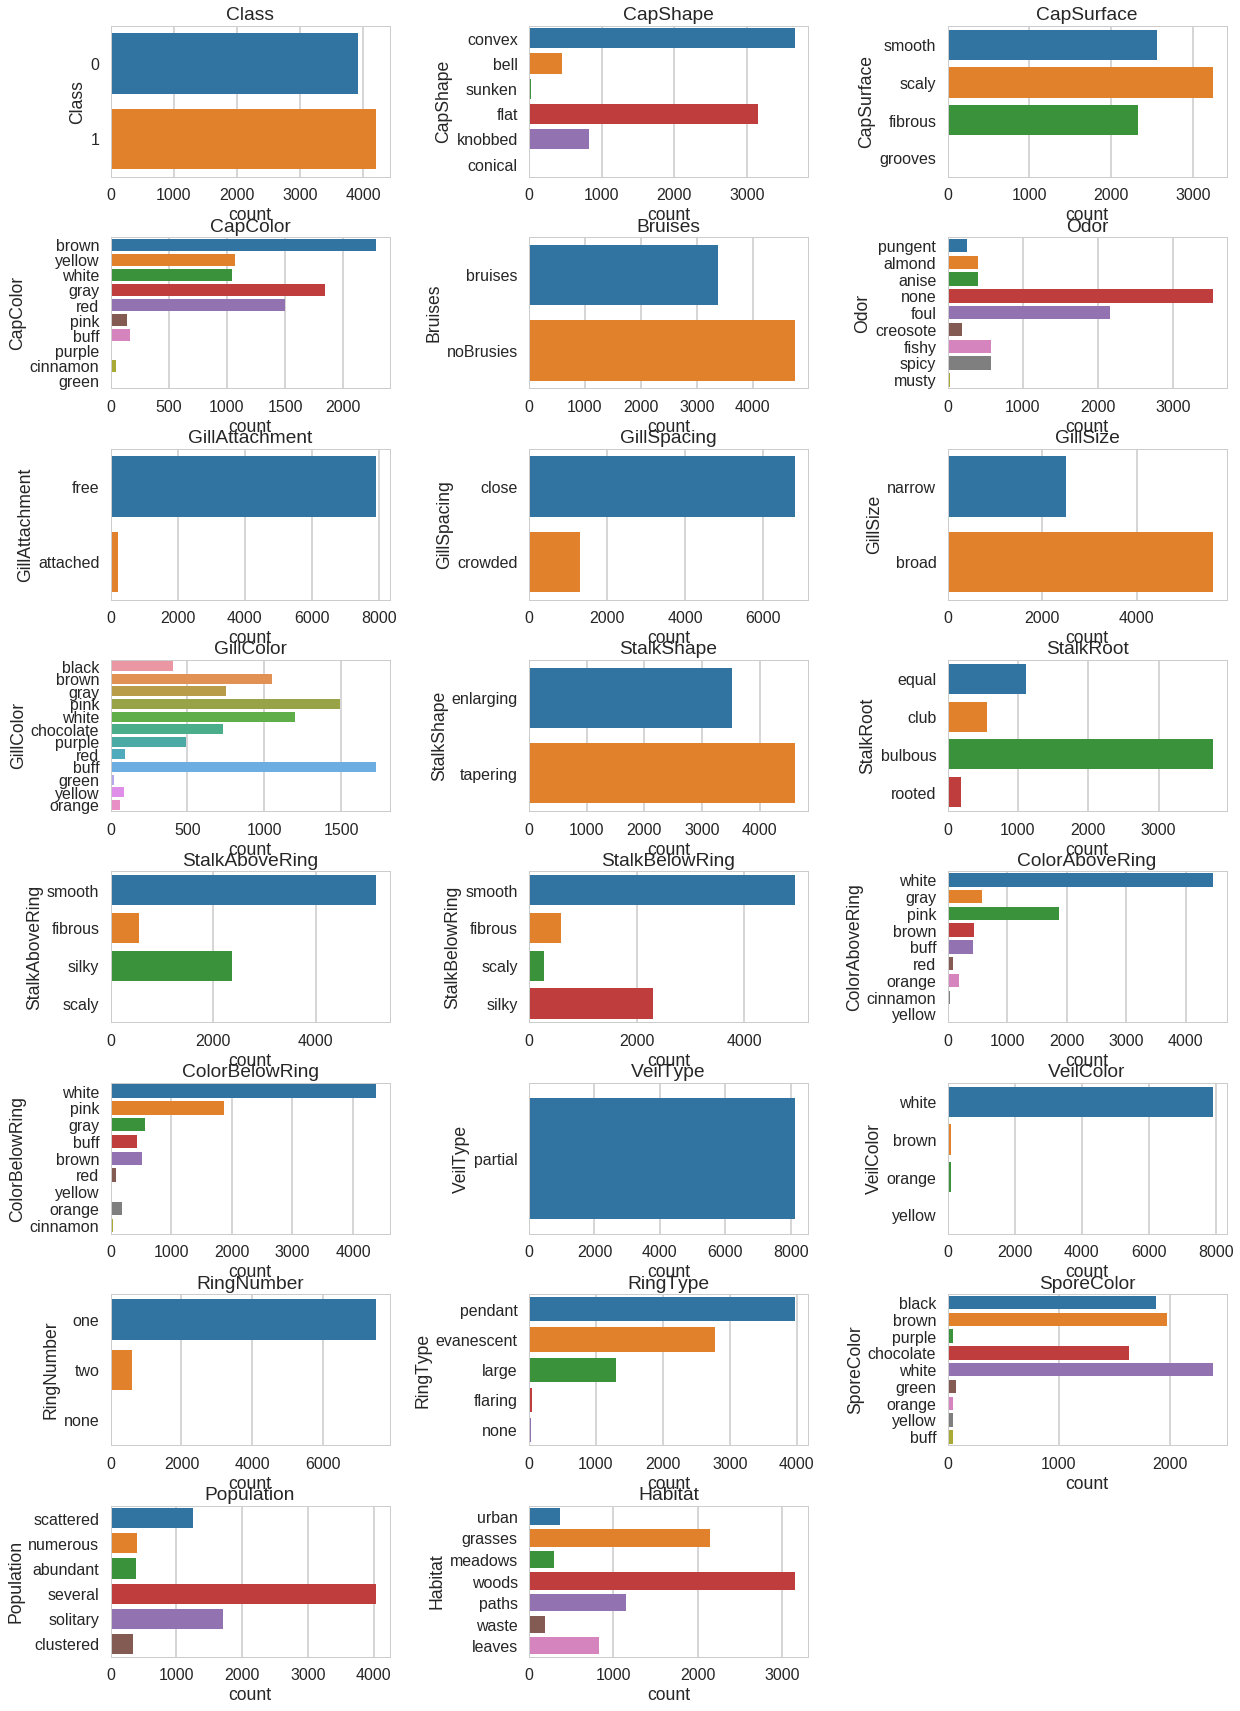

In [75]:
# Plot a count of the categories from each categorical feature split by our prediction class: salary - predclass.
def plot_bivariate_bar(dataset, hue, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    dataset = dataset.select_dtypes(include=[np.object])
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if dataset.dtypes[column] == np.object:
            #g = sns.countplot(y=column, hue=hue, data=dataset)
            g = sns.countplot(y=column, data=dataset)
            substrings = [s.get_text()[:10] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)

sns.set_context("poster", font_scale=1, rc={"lines.linewidth": 2.5})
plot_bivariate_bar(dataset_raw, hue='Class', cols=3, width=20, height=30, hspace=0.4, wspace=0.5)

## Contingency Table
A contingency table is a multi-way table that describes a data set in 
which each observation belongs to one category for each of several variables.

Let us see the results for Class and Habitat.

In [93]:

table = sm.stats.Table.from_data(dataset_raw[["Class", "Habitat"]])

**Independence** is the property that the row and column factors occur independently. **Association** is the lack of independence. If the joint distribution is independent, it can be written as the outer product of the row and column marginal distributions:



P_{ij} = sum_k P_{ij} cdot sum_k P_{kj} forall i, j

We can obtain the best-fitting independent distribution for our observed data, and then view residuals which identify particular cells that most strongly violate independence:

In [98]:
print("Table Original")
table.table_orig


Table Original


Habitat,grasses,leaves,meadows,paths,urban,waste,woods
Class,,,,,,,
0,740,592,36,1008,272,0,1268
1,1408,240,256,136,96,192,1880


If the rows and columns of a table are unordered (i.e. are nominal factors), then the most common approach for formally assessing independence is using Pearson’s \chi^2 statistic. It’s often useful to look at the cell-wise contributions to the \chi^2 statistic to see where the evidence for dependence is coming from.

In [126]:
rslt = table.test_ordinal_association()
print(rslt.pvalue)
print(rslt.null_mean)
print(rslt.null_sd)
print(rslt.statistic)
print(rslt.zscore)

0.0438802224455
13564.7489239
114.007191999
13794.5
2.01523318047


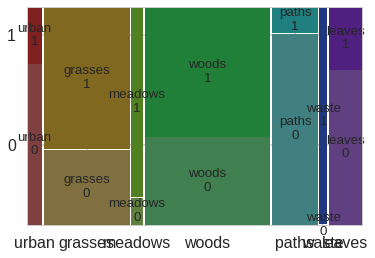

In [110]:
plt.rcParams['font.size'] = 16.0
mosaic(dataset_raw, ['Habitat', 'Class']);

Let's make a function for assessing the categorical variables as shown above

In [137]:
def Asses_variable(var1, var2):
    # Contigency Table
    table = sm.stats.Table.from_data(dataset_raw[[var1, var2]])
    print("\n\nTable Original")
    print(table.table_orig)
    
    # p-value
    rslt = table.test_ordinal_association()
    print("P-value is: ", rslt.pvalue)
    
    # Mosaic plot for visualization
    plt.rcParams['font.size'] = 16.0
    mosaic(dataset_raw, [var2, var1])
    return rslt.pvalue

In [138]:
# We will save all the p-values in a list
pvalues_list = []



Table Original
CapShape  bell  conical  convex  flat  knobbed  sunken
Class                                                 
0           48        4    1708  1556      600       0
1          404        0    1948  1596      228      32
P-value is:  4.33955269493e-72


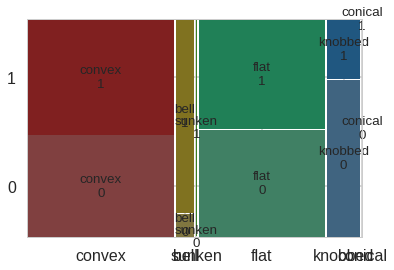

In [139]:
pval = Asses_variable('Class', 'CapShape')
pvalues_list.append(pval)



Table Original
CapSurface  fibrous  grooves  scaly  smooth
Class                                      
0               760        4   1740    1412
1              1560        0   1504    1144
P-value is:  1.41856018527e-63


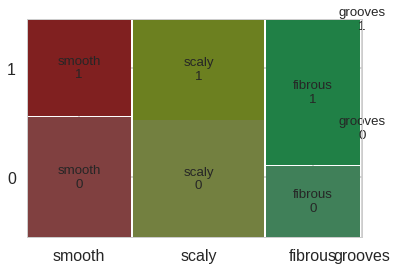

In [140]:
pval = Asses_variable('Class', 'CapSurface')
pvalues_list.append(pval)



Table Original
CapColor  brown  buff  cinnamon  gray  green  pink  purple  red  white  yellow
Class                                                                         
0          1020   120        12   808      0    88       0  876    320     672
1          1264    48        32  1032     16    56      16  624    720     400
P-value is:  1.39374239623e-07


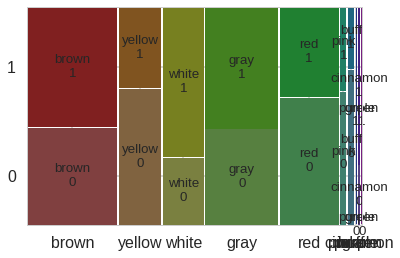

In [141]:
pval = Asses_variable('Class', 'CapColor')
pvalues_list.append(pval)



Table Original
Bruises  bruises  noBrusies
Class                      
0            624       3292
1           2752       1456
P-value is:  0.0


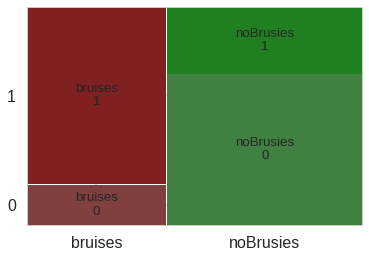

In [142]:
pval = Asses_variable('Class', 'Bruises')
pvalues_list.append(pval)



Table Original
Odor   almond  anise  creosote  fishy  foul  musty  none  pungent  spicy
Class                                                                   
0           0      0       192    576  2160     36   120      256    576
1         400    400         0      0     0      0  3408        0      0
P-value is:  5.43326852538e-15


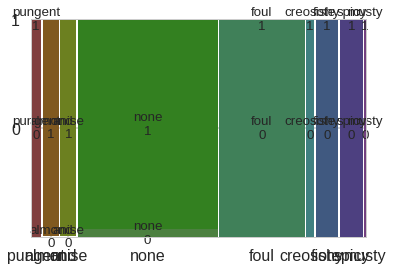

In [143]:
pval = Asses_variable('Class', 'Odor')
pvalues_list.append(pval)



Table Original
GillAttachment  attached  free
Class                         
0                     18  3898
1                    192  4016
P-value is:  2.44797093432e-31


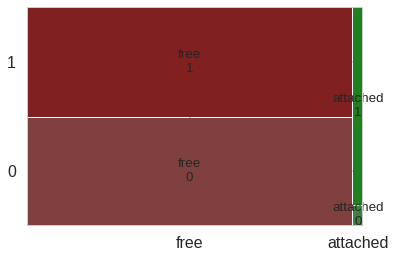

In [144]:
pval = Asses_variable('Class', 'GillAttachment')
pvalues_list.append(pval)



Table Original
GillSpacing  close  crowded
Class                      
0             3804      112
1             3008     1200
P-value is:  2.06870341869e-216


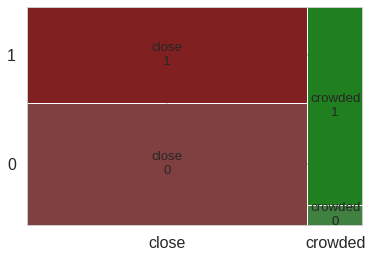

In [145]:
pval = Asses_variable('Class', 'GillSpacing')
pvalues_list.append(pval)



Table Original
GillSize  broad  narrow
Class                  
0          1692    2224
1          3920     288
P-value is:  0.0


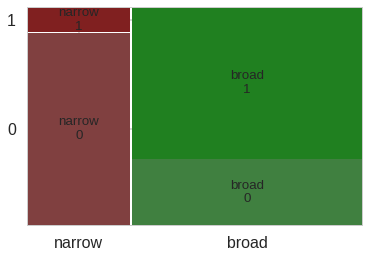

In [146]:
pval = Asses_variable('Class', 'GillSize')
pvalues_list.append(pval)



Table Original
GillColor  black  brown  buff  chocolate  gray  green  orange  pink  purple  \
Class                                                                         
0             64    112  1728        528   504     24       0   640      48   
1            344    936     0        204   248      0      64   852     444   

GillColor  red  white  yellow  
Class                          
0            0    246      22  
1           96    956      64  
P-value is:  8.26417234311e-131


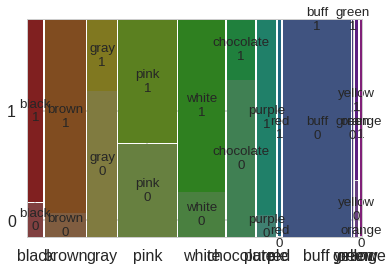

In [147]:
pval = Asses_variable('Class', 'GillColor')
pvalues_list.append(pval)



Table Original
StalkShape  enlarging  tapering
Class                          
0                1900      2016
1                1616      2592
P-value is:  3.75909352494e-20


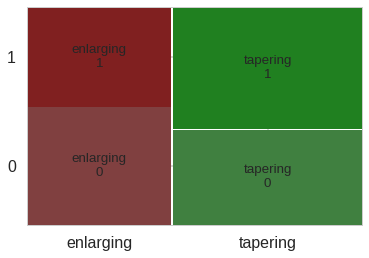

In [148]:
pval = Asses_variable('Class', 'StalkShape')
pvalues_list.append(pval)



Table Original
StalkRoot  bulbous  club  equal  rooted
Class                                  
0             1856    44    256       0
1             1920   512    864     192
P-value is:  1.22459516826e-105


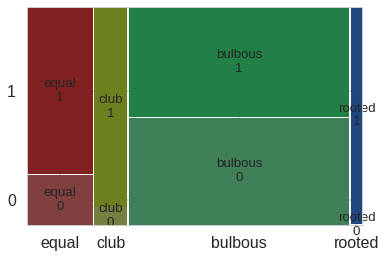

In [150]:
pval = Asses_variable('Class', 'StalkRoot')
pvalues_list.append(pval)



Table Original
StalkAboveRing  fibrous  scaly  silky  smooth
Class                                        
0                   144      8   2228    1536
1                   408     16    144    3640
P-value is:  1.02614183064e-83


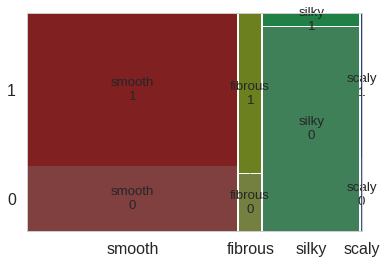

In [151]:
pval = Asses_variable('Class', 'StalkAboveRing')
pvalues_list.append(pval)



Table Original
StalkBelowRing  fibrous  scaly  silky  smooth
Class                                        
0                   144     76   2160    1536
1                   456    208    144    3400
P-value is:  3.94346142894e-36


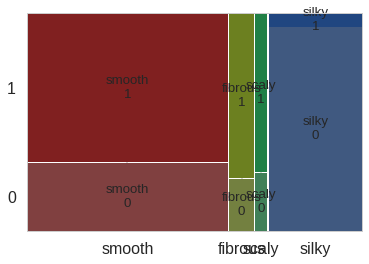

In [152]:
pval = Asses_variable('Class', 'StalkBelowRing')
pvalues_list.append(pval)



Table Original
ColorAboveRing  brown  buff  cinnamon  gray  orange  pink  red  white  yellow
Class                                                                        
0                 432   432        36     0       0  1296    0   1712       8
1                  16     0         0   576     192   576   96   2752       0
P-value is:  7.76776578014e-125


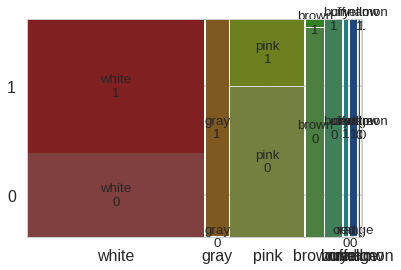

In [153]:
pval = Asses_variable('Class', 'ColorAboveRing')
pvalues_list.append(pval)



Table Original
ColorBelowRing  brown  buff  cinnamon  gray  orange  pink  red  white  yellow
Class                                                                        
0                 448   432        36     0       0  1296    0   1680      24
1                  64     0         0   576     192   576   96   2704       0
P-value is:  4.65234080779e-108


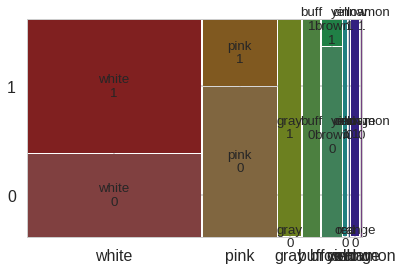

In [154]:
pval = Asses_variable('Class', 'ColorBelowRing')
pvalues_list.append(pval)



Table Original
VeilType  partial
Class            
0            3916
1            4208
P-value is:  nan


/opt/conda/lib/python3.6/site-packages/statsmodels/stats/contingency_tables.py:268: RuntimeWarning: invalid value encountered in double_scalars
  zscore = (statistic - e_stat) / sd_stat


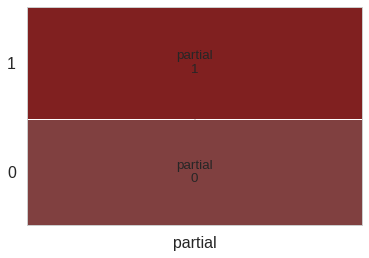

In [155]:
pval = Asses_variable('Class', 'VeilType')
pvalues_list.append(pval)



Table Original
VeilColor  brown  orange  white  yellow
Class                                  
0              0       0   3908       8
1             96      96   4016       0
P-value is:  1.24371720587e-38


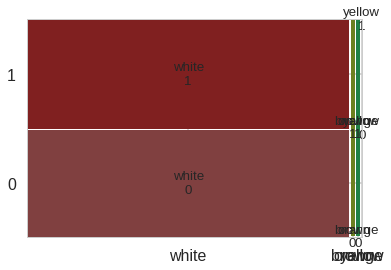

In [156]:
pval = Asses_variable('Class', 'VeilColor')
pvalues_list.append(pval)



Table Original
RingNumber  none   one  two
Class                      
0             36  3808   72
1              0  3680  528
P-value is:  6.75747761905e-83


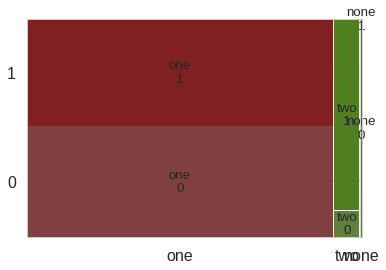

In [157]:
pval = Asses_variable('Class', 'RingNumber')
pvalues_list.append(pval)



Table Original
RingType  evanescent  flaring  large  none  pendant
Class                                              
0               1768        0   1296    36      816
1               1008       48      0     0     3152
P-value is:  2.33666080872e-301


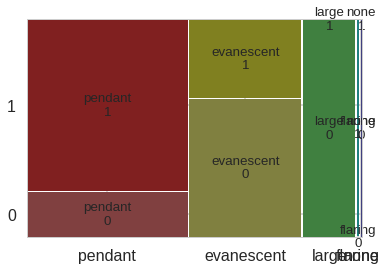

In [158]:
pval = Asses_variable('Class', 'RingType')
pvalues_list.append(pval)



Table Original
SporeColor  black  brown  buff  chocolate  green  orange  purple  white  \
Class                                                                     
0             224    224     0       1584     72       0       0   1812   
1            1648   1744    48         48      0      48      48    576   

SporeColor  yellow  
Class               
0                0  
1               48  
P-value is:  0.0


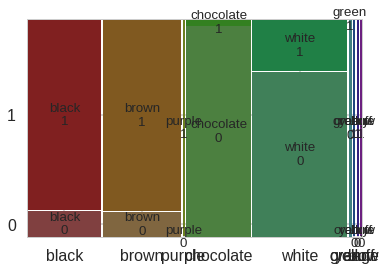

In [159]:
pval = Asses_variable('Class', 'SporeColor')
pvalues_list.append(pval)



Table Original
Population  abundant  clustered  numerous  scattered  several  solitary
Class                                                                  
0                  0         52         0        368     2848       648
1                384        288       400        880     1192      1064
P-value is:  2.80786981911e-159


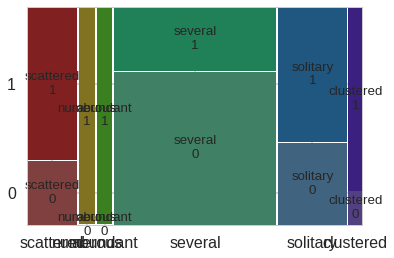

In [160]:
pval = Asses_variable('Class', 'Population')
pvalues_list.append(pval)



Table Original
Habitat  grasses  leaves  meadows  paths  urban  waste  woods
Class                                                        
0            740     592       36   1008    272      0   1268
1           1408     240      256    136     96    192   1880
P-value is:  0.0438802224455


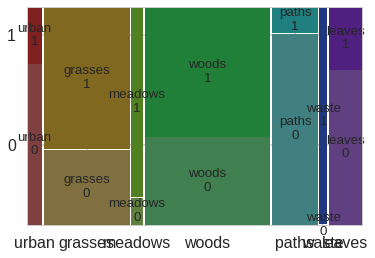

In [161]:
pval = Asses_variable('Class', 'Habitat')
pvalues_list.append(pval)

In [162]:
pvalues_list

[4.3395526949270334e-72,
 1.4185601852654719e-63,
 1.3937423962336559e-07,
 0.0,
 5.4332685253761371e-15,
 2.4479709343223031e-31,
 2.068703418689218e-216,
 0.0,
 8.2641723431114055e-131,
 3.759093524938306e-20,
 1.2245951682643509e-105,
 1.0261418306433979e-83,
 3.9434614289387446e-36,
 7.7677657801357386e-125,
 4.6523408077932309e-108,
 nan,
 1.2437172058747893e-38,
 6.757477619046886e-83,
 2.3366608087221796e-301,
 0.0,
 2.8078698191123422e-159,
 0.043880222445476902]

pvalue_list has all very low values, so all the features have strong relationship with "Class" variable.

## Feature Encoding

Remember that Machine Learning algorithms perform Linear Algebra on Matrices, which means all features need have numeric values. The process of converting Categorical Features into values is called Encoding. Let's perform both One-Hot and Label encoding.

Additional Resources: http://pbpython.com/categorical-encoding.html

In [176]:
# One Hot Encodes all labels before Machine Learning
one_hot_cols = dataset_bin.columns.tolist()
one_hot_cols.remove('Class')
dataset_bin_enc = pd.get_dummies(dataset_bin, columns=one_hot_cols)

dataset_bin_enc.head()

,Class,CapShape_b,CapShape_c,CapShape_f,CapShape_k,CapShape_s,CapShape_x,CapSurface_f,CapSurface_g,CapSurface_s,...,Population_s,Population_v,Population_y,Habitat_d,Habitat_g,Habitat_l,Habitat_m,Habitat_p,Habitat_u,Habitat_w
0,0,0,0,0,0,0,1,0,0,1,...,1,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [193]:
dataset_con_enc = pd.DataFrame({col: dataset_raw[col].astype('category').cat.codes for col in dataset_raw}, index=dataset_raw.index)

dataset_con_enc.head()

,Bruises,CapColor,CapShape,CapSurface,Class,ColorAboveRing,ColorBelowRing,GillAttachment,GillColor,GillSize,...,Population,RingNumber,RingType,SporeColor,StalkAboveRing,StalkBelowRing,StalkRoot,StalkShape,VeilColor,VeilType
0,0,0,2,3,0,7,7,1,0,1,...,3,1,4,0,3,3,2,0,2,0
1,0,9,2,3,1,7,7,1,0,0,...,2,1,4,1,3,3,1,0,2,0
2,0,8,0,3,1,7,7,1,1,0,...,2,1,4,1,3,3,1,0,2,0
3,0,8,2,2,0,7,7,1,1,1,...,3,1,4,0,3,3,2,0,2,0
4,1,3,2,3,1,7,7,1,0,0,...,0,1,0,1,3,3,2,1,2,0


## Feature Reduction / Selection

Once we have our features ready to use, we might find that the number of features available is too large to be run in a reasonable timeframe by our machine learning algorithms. There's a number of options available to us for feature reduction and feature selection.

- **Dimensionality Reduction:**
    - **Principal Component Analysis (PCA):** Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. This transformation is defined in such a way that the first principal component has the largest possible variance (that is, accounts for as much of the variability in the data as possible), and each succeeding component in turn has the highest variance possible under the constraint that it is orthogonal to the preceding components.
    - **Singular Value Decomposition (SVD):** SVD is a factorization of a real or complex matrix. It is the generalization of the eigendecomposition of a positive semidefinite normal matrix (for example, a symmetric matrix with positive eigenvalues) to any m×n  matrix via an extension of the polar decomposition. It has many useful applications in signal processing and statistics.


- **Feature Importance/Relevance:**
    - **Filter Methods:** Filter type methods select features based only on general metrics like the correlation with the variable to predict. Filter methods suppress the least interesting variables. The other variables will be part of a classification or a regression model used to classify or to predict data. These methods are particularly effective in computation time and robust to overfitting.
    - **Wrapper Methods:** Wrapper methods evaluate subsets of variables which allows, unlike filter approaches, to detect the possible interactions between variables. The two main disadvantages of these methods are : The increasing overfitting risk when the number of observations is insufficient. AND. The significant computation time when the number of variables is large.
    - **Embedded Methods:** Embedded methods try to combine the advantages of both previous methods. A learning algorithm takes advantage of its own variable selection process and performs feature selection and classification simultaneously.

### Feature Correlation

Correlation is a measure of how much two random variables change together. Features should be uncorrelated with each other and highly correlated to the feature we're trying to predict.

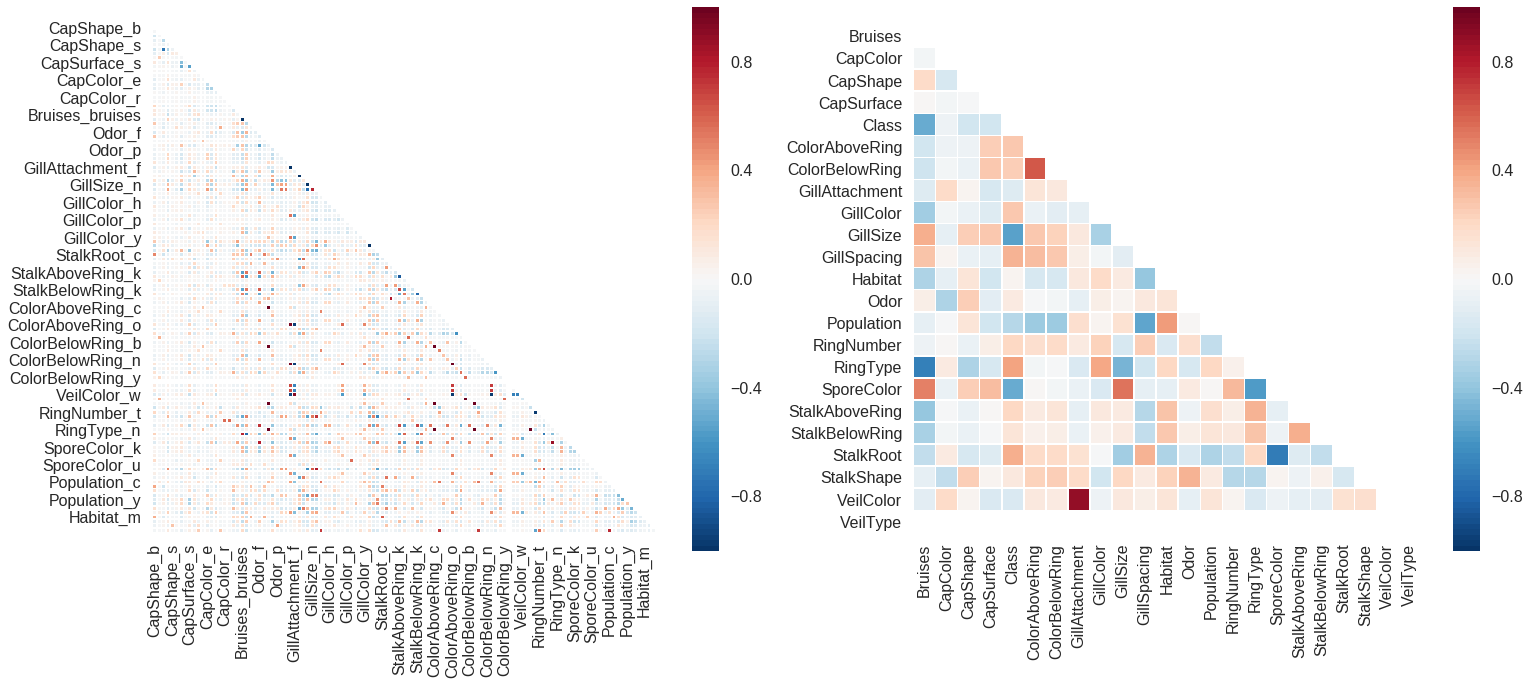

In [180]:
# Create a correlation plot of both datasets.
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(25,10))

plt.subplot(1,2,1)
#Generate the mask for the upper triangle
mask = np.zeros_like(dataset_bin_enc.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)]=True
sns.heatmap(dataset_bin_enc.corr(),
           vmin=-1, vmax=1,
           square=True,
           cmap=sns.color_palette("RdBu_r", 100),
           mask=mask,
           linewidths=0.5);

plt.subplot(1, 2, 2)
mask = np.zeros_like(dataset_con_enc.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(dataset_con_enc.corr(), 
            vmin=-1, vmax=1, 
            square=True, 
            cmap=sns.color_palette("RdBu_r", 100), 
            mask=mask, 
            linewidths=.5);

### Feature Importance

Random forest consists of a number of decision trees. Every node in the decision trees is a condition on a single feature, designed to split the dataset into two so that similar response values end up in the same set. The measure based on which the (locally) optimal condition is chosen is called impurity. When training a tree, it can be computed how much each feature decreases the weighted impurity in a tree. For a forest, the impurity decrease from each feature can be averaged and the features are ranked according to this measure. This is the feature importance measure exposed in sklearn’s Random Forest implementations.

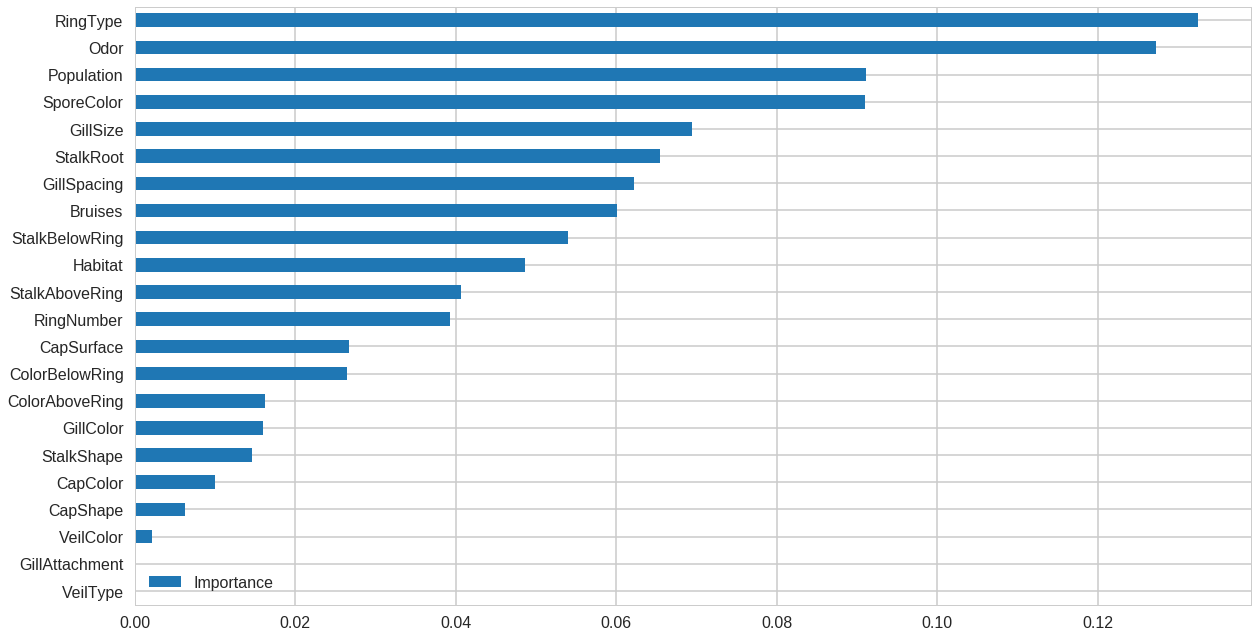

In [183]:
# Using Random Forest to gain an insight on Feature Importance
clf = RandomForestClassifier()
clf.fit(dataset_con_enc.drop('Class', axis=1), dataset_con_enc['Class'])

plt.style.use('seaborn-whitegrid')
importance = clf.feature_importances_
importance = pd.DataFrame(importance, index=dataset_con_enc.drop('Class', axis=1).columns, columns=["Importance"])
importance.sort_values(by='Importance', ascending=True).plot(kind='barh', figsize=(20,len(importance)/2));

## PCA

Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. This transformation is defined in such a way that the first principal component has the largest possible variance (that is, accounts for as much of the variability in the data as possible), and each succeeding component in turn has the highest variance possible under the constraint that it is orthogonal to the preceding components.

We can use PCA to reduce the number of features to use in our ML algorithms, and graphing the variance gives us an idea of how many features we really need to represent our dataset fully.

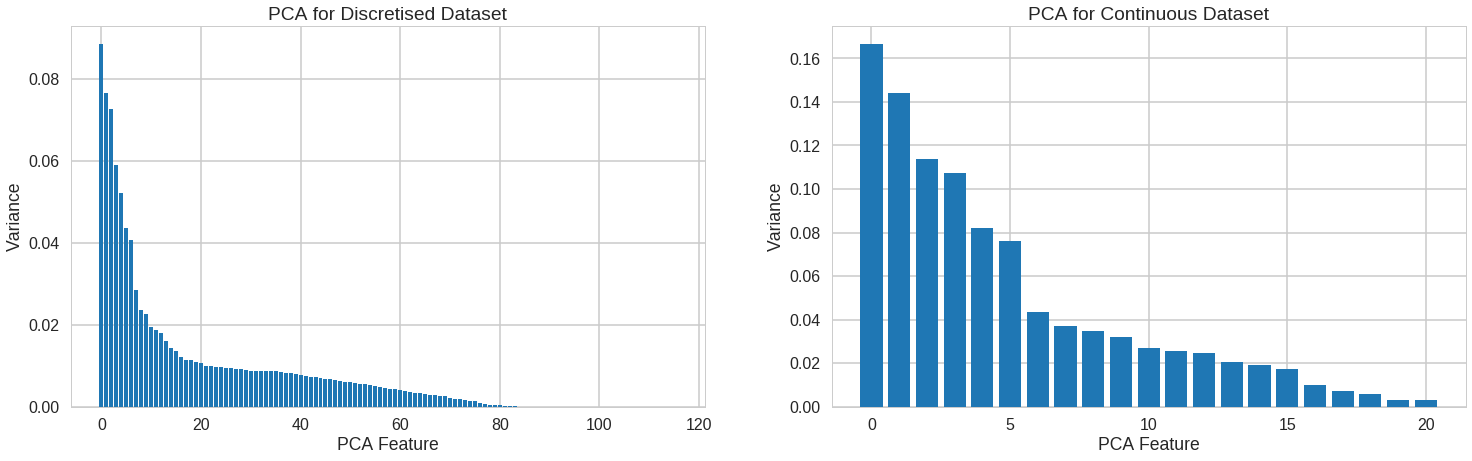

In [184]:
# Calculating PCA for both datasets, and graphing the Variance for each feature, per dataset
std_scale = preprocessing.StandardScaler().fit(dataset_bin_enc.drop('Class', axis=1))
X = std_scale.transform(dataset_bin_enc.drop('Class', axis=1))
pca1 = PCA(n_components=len(dataset_bin_enc.columns)-1)
fit1 = pca1.fit(X)

std_scale = preprocessing.StandardScaler().fit(dataset_con_enc.drop('Class', axis=1))
X = std_scale.transform(dataset_con_enc.drop('Class', axis=1))
pca2 = PCA(n_components=len(dataset_con_enc.columns)-2)
fit2 = pca2.fit(X)

# Graphing the variance per feature
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(25,7)) 

plt.subplot(1, 2, 1)
plt.xlabel('PCA Feature')
plt.ylabel('Variance')
plt.title('PCA for Discretised Dataset')
plt.bar(range(0, fit1.explained_variance_ratio_.size), fit1.explained_variance_ratio_);

plt.subplot(1, 2, 2)
plt.xlabel('PCA Feature')
plt.ylabel('Variance')
plt.title('PCA for Continuous Dataset')
plt.bar(range(0, fit2.explained_variance_ratio_.size), fit2.explained_variance_ratio_);

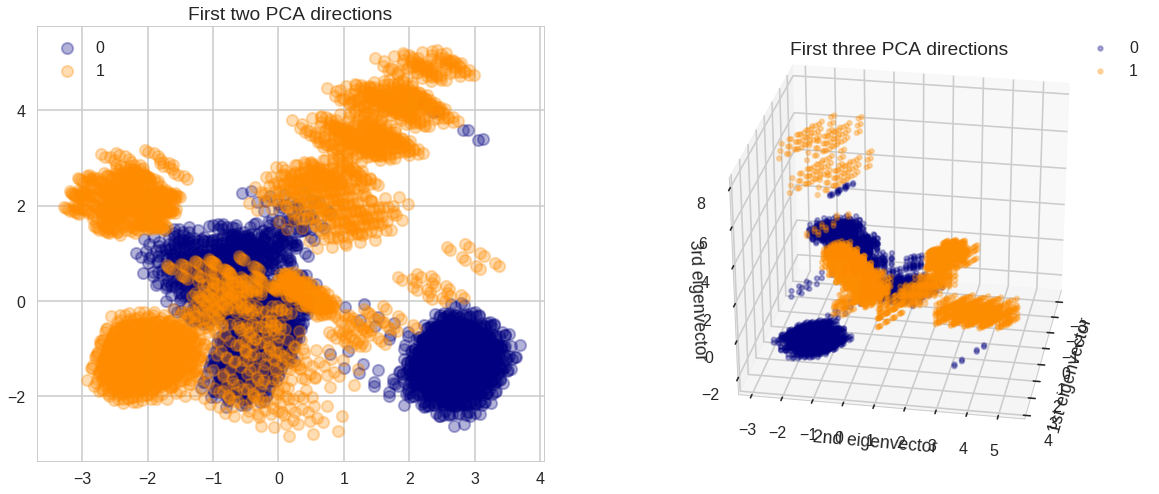

In [185]:
# PCA's components graphed in 2D and 3D
# Apply Scaling 
std_scale = preprocessing.StandardScaler().fit(dataset_con_enc.drop('Class', axis=1))
X = std_scale.transform(dataset_con_enc.drop('Class', axis=1))
y = dataset_con_enc['Class']

# Formatting
target_names = [0,1]
colors = ['navy','darkorange']
lw = 2
alpha = 0.3
# 2 Components PCA
plt.style.use('seaborn-whitegrid')
plt.figure(2, figsize=(20, 8))

plt.subplot(1, 2, 1)
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], 
                color=color, 
                alpha=alpha, 
                lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('First two PCA directions');

# 3 Components PCA
ax = plt.subplot(1, 2, 2, projection='3d')

pca = PCA(n_components=3)
X_reduced = pca.fit(X).transform(X)
for color, i, target_name in zip(colors, [0, 1], target_names):
    ax.scatter(X_reduced[y == i, 0], X_reduced[y == i, 1], X_reduced[y == i, 2], 
               color=color,
               alpha=alpha,
               lw=lw, 
               label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.set_ylabel("2nd eigenvector")
ax.set_zlabel("3rd eigenvector")

# rotate the axes
ax.view_init(30, 10)

### Recursive Feature Elimination

Feature ranking with recursive feature elimination and cross-validated selection of the best number of features.

Feature Ranking For Non-Discretised: [ 3 15 12  4  8 14  2 11  1  1  9 13 10  1  5  6  1  7  1  1  1 16]
Optimal number of features : 7


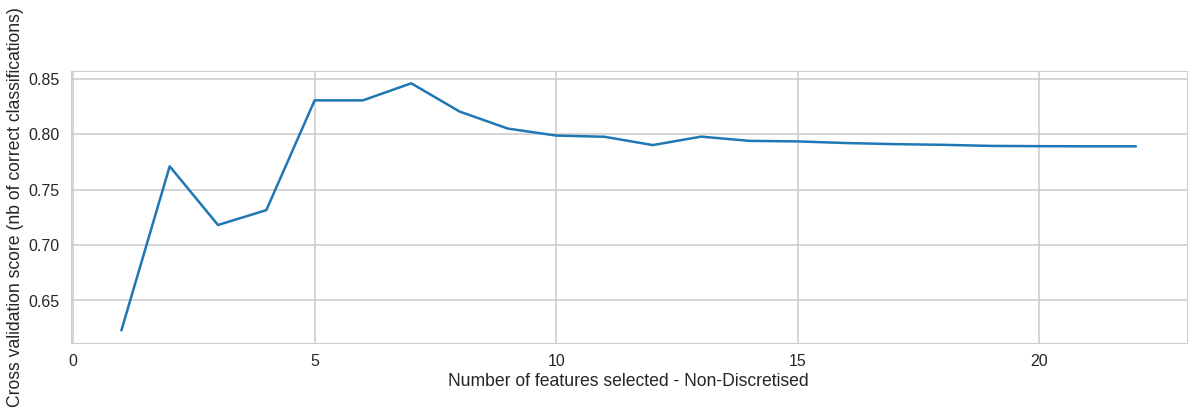

In [195]:
# Calculating RFE for non-discretised dataset, and graphing the Importance for each feature, per dataset
selector1 = RFECV(LogisticRegression(), step=1, cv=5, n_jobs=-1)
selector1 = selector1.fit(dataset_con_enc.drop('Class', axis=1).values, dataset_con_enc['Class'].values)
print("Feature Ranking For Non-Discretised: %s" % selector1.ranking_)
print("Optimal number of features : %d" % selector1.n_features_)
# Plot number of features VS. cross-validation scores
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(20,5)) 
plt.xlabel("Number of features selected - Non-Discretised")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(selector1.grid_scores_) + 1), selector1.grid_scores_);

# Feature space could be subsetted like so:
#dataset_con_enc = dataset_con_enc[dataset_con_enc.columns[np.insert(selector1.support_, 0, True)]]

### Selecting Dataset

We now have two datasets to choose from to apply our ML algorithms. The one-hot-encoded, and the label-encoded. For now, we have decided not to use feature reduction or selection algorithms.

In [196]:
# OPTIONS:
# - dataset_bin_enc
# - dataset_con_enc

# Change the dataset to test how would te algorithm perform under differently encoded datasets.

selected_dataset = dataset_con_enc
selected_dataset.head()

,Bruises,CapColor,CapShape,CapSurface,Class,ColorAboveRing,ColorBelowRing,GillAttachment,GillColor,GillSize,...,Population,RingNumber,RingType,SporeColor,StalkAboveRing,StalkBelowRing,StalkRoot,StalkShape,VeilColor,VeilType
0,0,0,2,3,0,7,7,1,0,1,...,3,1,4,0,3,3,2,0,2,0
1,0,9,2,3,1,7,7,1,0,0,...,2,1,4,1,3,3,1,0,2,0
2,0,8,0,3,1,7,7,1,1,0,...,2,1,4,1,3,3,1,0,2,0
3,0,8,2,2,0,7,7,1,1,1,...,3,1,4,0,3,3,2,0,2,0
4,1,3,2,3,1,7,7,1,0,0,...,0,1,0,1,3,3,2,1,2,0


## Splitting Data into Training and Testing Datasets

In [197]:
# Splitting dataset into train adn test data
train = selected_dataset.sample(frac=0.7)
test = selected_dataset.loc[~selected_dataset.index.isin(train.index)]
print(train.shape)
print(test.shape)

(5687, 23)
(2437, 23)


### Removing Samples with Missing data

We could have removed rows with missing data during feature cleaning, but we're choosing to do it at this point. It's easier to do it this way, right after we split the data into Training and Testing. Otherwise we would have had to keep track of the number of deleted rows in our data and take that into account when deciding on a splitting boundary for our joined data.

In [198]:
# Given missing fields are a small percentange of the overall dataset, 
# we have chosen to delete them.
train = train.dropna(axis=0)
test = test.dropna(axis=0)

In [199]:
train.shape

(5687, 23)

In [202]:
test.shape

(2437, 23)

### Rename datasets before Machine Learning algos

In [200]:
X_train_w_label = train
X_train = train.drop(['Class'], axis=1)
y_train = train['Class'].astype('int64')
X_test = test.drop(['Class'], axis=1)
y_test = test['Class'].astype('int64')

# Machine Learning Algorthims

### Data review

Let's see our data.

In [201]:
X_train.shape

(5687, 22)

In [203]:
X_train.head()

,Bruises,CapColor,CapShape,CapSurface,ColorAboveRing,ColorBelowRing,GillAttachment,GillColor,GillSize,GillSpacing,...,Population,RingNumber,RingType,SporeColor,StalkAboveRing,StalkBelowRing,StalkRoot,StalkShape,VeilColor,VeilType
770,0,8,2,3,7,7,1,10,0,0,...,2,1,4,1,3,3,1,0,2,0
8106,1,0,4,3,4,4,0,6,0,0,...,4,1,4,1,3,3,-1,0,1,0
2763,0,3,2,2,7,3,1,8,0,0,...,4,1,4,1,3,3,0,1,2,0
280,0,8,2,2,7,7,1,10,1,0,...,3,1,4,1,3,3,2,0,2,0
3532,0,3,3,2,3,3,1,1,0,0,...,5,1,4,0,3,3,0,1,2,0


In [204]:
y_train.head()

770     1
8106    1
2763    1
280     0
3532    1
Name: Class, dtype: int64

In [205]:
# Setting a random seed will guarantee we get the same results 
# every time we run our training and testing.
random.seed(18)

### Algorithms

From here, we will be running the following algorithms.

- KNN
- Logistic Regression
- Random Forest
- Naive Bayes
- Stochastic Gradient Decent
- Linear SVC
- Decision Tree
- Gradient Boosted Trees

Because there's a great deal of repetitiveness on the code for each, we'll create a custom function to analyse this.

For some algorithms, we have also chosen to run a Random Hyperparameter search, to select the best hyperparameters for a given algorithm.

In [206]:
# calculate the fpr and tpr for all thresholds of the classification
def plot_roc_curve(y_test, preds):
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [207]:
# Function that runs the requested algorithm and returns the accuracy metrics
def fit_ml_algo(algo, X_train, y_train, X_test, cv):
    # One Pass
    model = algo.fit(X_train, y_train)
    test_pred = model.predict(X_test)
    if (isinstance(algo, (LogisticRegression, 
                          KNeighborsClassifier, 
                          GaussianNB, 
                          DecisionTreeClassifier, 
                          RandomForestClassifier,
                          GradientBoostingClassifier))):
        probs = model.predict_proba(X_test)[:,1]
    else:
        probs = "Not Available"
    acc = round(model.score(X_test, y_test) * 100, 2) 
    # CV 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    return train_pred, test_pred, acc, acc_cv, probs

In [208]:
# Logistic Regression - Random Search for Hyperparameters

# Utility function to report best scores
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
# Specify parameters and distributions to sample from
param_dist = {'penalty': ['l2', 'l1'], 
                         'class_weight': [None, 'balanced'],
                         'C': np.logspace(-20, 20, 10000), 
                         'intercept_scaling': np.logspace(-20, 20, 10000)}

# Run Randomized Search
n_iter_search = 10
lrc = LogisticRegression()
random_search = RandomizedSearchCV(lrc, 
                                   n_jobs=-1, 
                                   param_distributions=param_dist, 
                                   n_iter=n_iter_search)

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 82.07 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.950 (std: 0.011)
Parameters: {'penalty': 'l1', 'intercept_scaling': 553954822403977.12, 'class_weight': 'balanced', 'C': 918113323.04730904}

Model with rank: 1
Mean validation score: 0.950 (std: 0.011)
Parameters: {'penalty': 'l2', 'intercept_scaling': 9.9288669253001964e-12, 'class_weight': 'balanced', 'C': 1017421123378848.2}

Model with rank: 3
Mean validation score: 0.950 (std: 0.012)
Parameters: {'penalty': 'l2', 'intercept_scaling': 1.0380101976981037e-18, 'class_weight': 'balanced', 'C': 365979151256618.31}

Model with rank: 3
Mean validation score: 0.950 (std: 0.012)
Parameters: {'penalty': 'l1', 'intercept_scaling': 4.3728449275615729e-13, 'class_weight': 'balanced', 'C': 8009222505505983.0}

Model with rank: 5
Mean validation score: 0.949 (std: 0.011)
Parameters: {'penalty': 'l1', 'intercept_scaling': 1.109441763874374e-09, 'class_weight': None, 'C': 829644

In [209]:
# Logistic Regression
start_time = time.time()
train_pred_log, test_pred_log, acc_log, acc_cv_log, probs_log = fit_ml_algo(LogisticRegression(n_jobs = -1), 
                                                                 X_train, 
                                                                 y_train, 
                                                                 X_test, 
                                                                 10)
log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 94.83
Accuracy CV 10-Fold: 94.0
Running Time: 0:00:02.461563


In [210]:
#from sklearn.metrics import classification_report
print(metrics.classification_report(y_train, train_pred_log))

             precision    recall  f1-score   support

          0       0.95      0.92      0.94      2747
          1       0.93      0.95      0.94      2940

avg / total       0.94      0.94      0.94      5687



In [211]:
print(metrics.classification_report(y_test, test_pred_log))

             precision    recall  f1-score   support

          0       0.96      0.93      0.95      1169
          1       0.94      0.96      0.95      1268

avg / total       0.95      0.95      0.95      2437



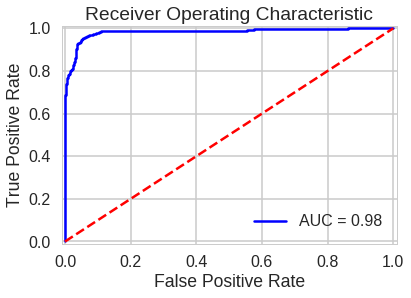

In [212]:
plot_roc_curve(y_test, probs_log)

In [213]:
# k-Nearest Neighbors
start_time = time.time()
train_pred_knn, test_pred_knn, acc_knn, acc_cv_knn, probs_knn = fit_ml_algo(KNeighborsClassifier(n_neighbors = 3,
                                                                                                 n_jobs = -1), 
                                                                                                 X_train, 
                                                                                                 y_train, 
                                                                                                 X_test, 
                                                                                                 10)
knn_time = (time.time() - start_time)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print("Running Time: %s" % datetime.timedelta(seconds=knn_time))

Accuracy: 100.0
Accuracy CV 10-Fold: 99.98
Running Time: 0:00:02.261064


In [214]:
print(metrics.classification_report(y_train, train_pred_knn))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      2747
          1       1.00      1.00      1.00      2940

avg / total       1.00      1.00      1.00      5687



In [215]:
print(metrics.classification_report(y_test, test_pred_knn))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1169
          1       1.00      1.00      1.00      1268

avg / total       1.00      1.00      1.00      2437



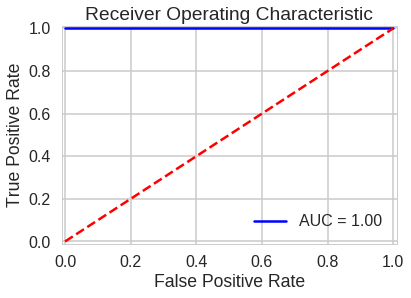

In [216]:
plot_roc_curve(y_test, probs_knn)

In [217]:
# Gaussian Naive Bayes
start_time = time.time()
train_pred_gaussian, test_pred_gaussian, acc_gaussian, acc_cv_gaussian, probs_gau = fit_ml_algo(GaussianNB(), 
                                                                                     X_train, 
                                                                                     y_train, 
                                                                                     X_test, 
                                                                                     10)
gaussian_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gaussian)
print("Accuracy CV 10-Fold: %s" % acc_cv_gaussian)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Accuracy: 87.44
Accuracy CV 10-Fold: 85.97
Running Time: 0:00:01.520640


In [218]:
print(metrics.classification_report(y_train, train_pred_gaussian))

             precision    recall  f1-score   support

          0       0.84      0.88      0.86      2747
          1       0.88      0.84      0.86      2940

avg / total       0.86      0.86      0.86      5687



In [219]:
print(metrics.classification_report(y_test, test_pred_gaussian))

             precision    recall  f1-score   support

          0       0.86      0.89      0.87      1169
          1       0.89      0.86      0.88      1268

avg / total       0.88      0.87      0.87      2437



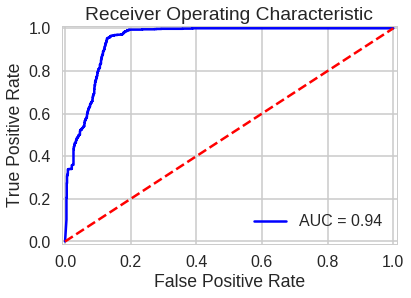

In [220]:
plot_roc_curve(y_test, probs_gau)

In [221]:
# Linear SVC
start_time = time.time()
train_pred_svc, test_pred_svc, acc_linear_svc, acc_cv_linear_svc, _ = fit_ml_algo(LinearSVC(),
                                                                                           X_train, 
                                                                                           y_train,
                                                                                           X_test, 
                                                                                           10)
linear_svc_time = (time.time() - start_time)
print("Accuracy: %s" % acc_linear_svc)
print("Accuracy CV 10-Fold: %s" % acc_cv_linear_svc)
print("Running Time: %s" % datetime.timedelta(seconds=linear_svc_time))

Accuracy: 94.34
Accuracy CV 10-Fold: 93.67
Running Time: 0:00:05.338731


In [222]:
print(metrics.classification_report(y_train, train_pred_svc))

             precision    recall  f1-score   support

          0       0.95      0.92      0.93      2747
          1       0.93      0.95      0.94      2940

avg / total       0.94      0.94      0.94      5687



In [223]:
print(metrics.classification_report(y_test, test_pred_svc)) 

             precision    recall  f1-score   support

          0       0.96      0.92      0.94      1169
          1       0.93      0.97      0.95      1268

avg / total       0.94      0.94      0.94      2437



In [224]:
# Stochastic Gradient Descent
start_time = time.time()
train_pred_sgd, test_pred_sgd, acc_sgd, acc_cv_sgd, _ = fit_ml_algo(SGDClassifier(n_jobs = -1), 
                                                                 X_train, 
                                                                 y_train, 
                                                                 X_test, 
                                                                 10)
sgd_time = (time.time() - start_time)
print("Accuracy: %s" % acc_sgd)
print("Accuracy CV 10-Fold: %s" % acc_cv_sgd)
print("Running Time: %s" % datetime.timedelta(seconds=sgd_time))

Accuracy: 85.8
Accuracy CV 10-Fold: 82.98
Running Time: 0:00:01.253216


In [225]:
print(metrics.classification_report(y_train, train_pred_sgd))

             precision    recall  f1-score   support

          0       0.80      0.85      0.83      2747
          1       0.86      0.81      0.83      2940

avg / total       0.83      0.83      0.83      5687



In [226]:
print(metrics.classification_report(y_test, test_pred_sgd))

             precision    recall  f1-score   support

          0       0.77      1.00      0.87      1169
          1       0.99      0.73      0.84      1268

avg / total       0.89      0.86      0.86      2437



In [227]:
# Decision Tree Classifier
start_time = time.time()
train_pred_dt, test_pred_dt, acc_dt, acc_cv_dt, probs_dt = fit_ml_algo(DecisionTreeClassifier(), 
                                                             X_train, 
                                                             y_train, 
                                                             X_test, 
                                                             10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 100.0
Accuracy CV 10-Fold: 100.0
Running Time: 0:00:01.295149


In [228]:
print(metrics.classification_report(y_train, train_pred_dt))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      2747
          1       1.00      1.00      1.00      2940

avg / total       1.00      1.00      1.00      5687



In [229]:
print(metrics.classification_report(y_test, test_pred_dt))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1169
          1       1.00      1.00      1.00      1268

avg / total       1.00      1.00      1.00      2437



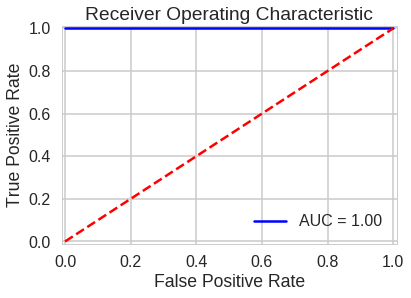

In [230]:
plot_roc_curve(y_test, probs_dt)

In [231]:
# Random Forest Classifier - Random Search for Hyperparameters

# Utility function to report best scores
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
# Specify parameters and distributions to sample from
param_dist = {"max_depth": [10, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 20),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# Run Randomized Search
n_iter_search = 10
rfc = RandomForestClassifier(n_estimators=10)
random_search = RandomizedSearchCV(rfc, 
                                   n_jobs = -1, 
                                   param_distributions=param_dist, 
                                   n_iter=n_iter_search)

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 2.31 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 9, 'min_samples_leaf': 9, 'min_samples_split': 3}

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 2, 'min_samples_leaf': 5, 'min_samples_split': 17}

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 9, 'min_samples_leaf': 4, 'min_samples_split': 15}

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 12}

Model with rank: 5
Mean validation score: 1.000 (std: 0.000)
Parameters: {'bootstrap': True, 'criterion': 'entropy'

In [232]:
# Random Forest Classifier
start_time = time.time()
rfc = RandomForestClassifier(n_estimators=10, 
                             min_samples_leaf=2,
                             min_samples_split=17, 
                             criterion='gini', 
                             max_features=8)
train_pred_rf, test_pred_rf, acc_rf, acc_cv_rf, probs_rf = fit_ml_algo(rfc, 
                                                             X_train, 
                                                             y_train, 
                                                             X_test, 
                                                             10)
rf_time = (time.time() - start_time)
print("Accuracy: %s" % acc_rf)
print("Accuracy CV 10-Fold: %s" % acc_cv_rf)
print("Running Time: %s" % datetime.timedelta(seconds=rf_time))

Accuracy: 100.0
Accuracy CV 10-Fold: 100.0
Running Time: 0:00:01.680477


In [233]:
print(metrics.classification_report(y_train, train_pred_rf))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      2747
          1       1.00      1.00      1.00      2940

avg / total       1.00      1.00      1.00      5687



In [234]:
print(metrics.classification_report(y_test, test_pred_rf))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1169
          1       1.00      1.00      1.00      1268

avg / total       1.00      1.00      1.00      2437



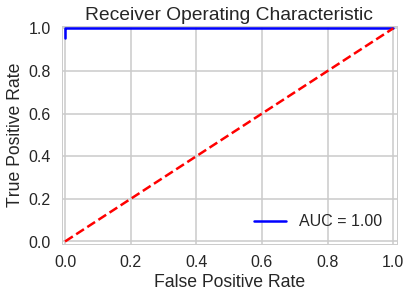

In [235]:
plot_roc_curve(y_test, probs_rf)

In [236]:
# Gradient Boosting Trees
start_time = time.time()
train_pred_gbt, test_pred_gbt, acc_gbt, acc_cv_gbt, probs_gbt = fit_ml_algo(GradientBoostingClassifier(), 
                                                                 X_train, 
                                                                 y_train, 
                                                                 X_test, 
                                                                 10)
gbt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Running Time: %s" % datetime.timedelta(seconds=gbt_time))

Accuracy: 100.0
Accuracy CV 10-Fold: 100.0
Running Time: 0:00:05.560991


In [237]:
print(metrics.classification_report(y_train, train_pred_gbt))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      2747
          1       1.00      1.00      1.00      2940

avg / total       1.00      1.00      1.00      5687



In [238]:
print(metrics.classification_report(y_test, test_pred_gbt))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1169
          1       1.00      1.00      1.00      1268

avg / total       1.00      1.00      1.00      2437



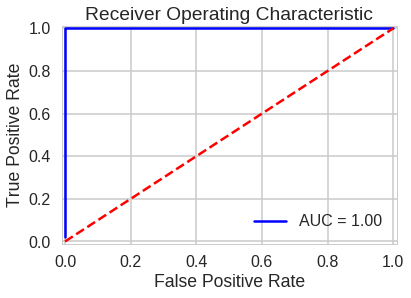

In [239]:
plot_roc_curve(y_test, probs_gbt)

## Ranking Results

Let's rank the results for all the algorithms we have used

In [240]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees'],
    'Score': [
        acc_knn, 
        acc_log, 
        acc_rf, 
        acc_gaussian, 
        acc_sgd, 
        acc_linear_svc, 
        acc_dt,
        acc_gbt
    ]})
models.sort_values(by='Score', ascending=False)

,Model,Score
0,KNN,100.00
2,Random Forest,100.00
6,Decision Tree,100.00
7,Gradient Boosting Trees,100.00
1,Logistic Regression,94.83
5,Linear SVC,94.34
3,Naive Bayes,87.44
4,Stochastic Gradient Decent,85.80


In [241]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees'],
    'Score': [
        acc_cv_knn, 
        acc_cv_log,     
        acc_cv_rf, 
        acc_cv_gaussian, 
        acc_cv_sgd, 
        acc_cv_linear_svc, 
        acc_cv_dt,
        acc_cv_gbt
    ]})
models.sort_values(by='Score', ascending=False)

,Model,Score
2,Random Forest,100.00
6,Decision Tree,100.00
7,Gradient Boosting Trees,100.00
0,KNN,99.98
1,Logistic Regression,94.00
5,Linear SVC,93.67
3,Naive Bayes,85.97
4,Stochastic Gradient Decent,82.98


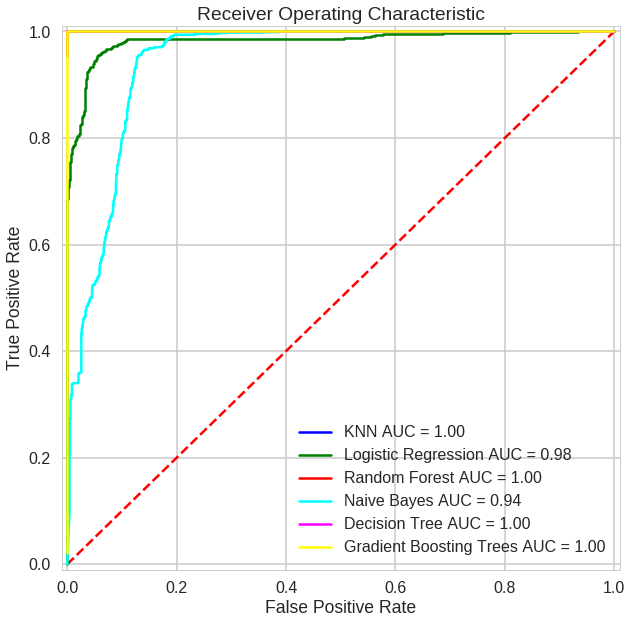

In [242]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(10,10)) 

models = [
    'KNN', 
    'Logistic Regression', 
    'Random Forest', 
    'Naive Bayes', 
    'Decision Tree', 
    'Gradient Boosting Trees'
]
probs = [
    probs_knn,
    probs_log,
    probs_rf,
    probs_gau,
    probs_dt,
    probs_gbt
]
colors = [
    'blue',
    'green',
    'red',
    'cyan',
    'magenta',
    'yellow',
]
    
plt.title('Receiver Operating Characteristic')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

def plot_roc_curves(y_test, prob, model):
    fpr, tpr, threshold = metrics.roc_curve(y_test, prob)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = model + ' AUC = %0.2f' % roc_auc, color=colors[i])
    plt.legend(loc = 'lower right')
    
for i, model in list(enumerate(models)):
    plot_roc_curves(y_test, probs[i], models[i])
    
plt.show()

In this dataset, Random Forest, Decision Trees and Gradient Boosting Trees performed very well. KNN also performed better than other remaining algorithms.